<a href="https://colab.research.google.com/github/lotrmay/TensorFlow_Learning/blob/master/bc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import pickle
import keras
import numpy as np #better arrays in python, lepší práce s multidimenzionálními poli
import pandas as pd #data analytics tool, lepší manipulace s daty, dokáže například cut outnout column
import matplotlib.pyplot as plt #vizualizace tabulek a grafů
import sklearn
from google.colab import drive
from sklearn.preprocessing import StandardScaler

#CSV_COLUMN_NAMES označuje nadpisy sloupců v csv soubour
CSV_COLUMN_NAMES=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg','Match_link','Result','team_one_name','team_two_name']

dataset=pd.read_csv('/content/data.csv',sep=";",names=CSV_COLUMN_NAMES,error_bad_lines=False,header=None)#vytvoří dataframe z našeho csv souboru
print(dataset.shape)#vypíše nám dimenzionalitu našeho dataframu např.(2, 3) 2 řádky 3 sloupce

#následující 2 řádky nám upraví dva sloupce z textových na číselné formáty (category datatype)
dataset['team_one_name']=pd.Categorical(dataset['team_one_name']).codes #sníží využití paměti z 1.2MB na 0.03 MB viz: https://towardsdatascience.com/staying-sane-while-adopting-pandas-categorical-datatypes-78dbd19dcd8a
dataset['team_two_name']=pd.Categorical(dataset['team_two_name']).codes

#Odstraním z dataframu následující sloupce (odkaz na zápas a jména týmů), jelikož jsem je využíval pouze při sběru dat
dataset.pop('Match_link')
dataset.pop('team_one_name')
dataset.pop('team_two_name')
#https://stackoverflow.com/questions/29576430/shuffle-dataframe-rows
#frac=1 znamená, vrať všechny řádky
dataset = dataset.sample(frac=1).reset_index(drop=True) #náhodně zamícháme řádky (můžeme využít seed)

main_scaler=sklearn.preprocessing.StandardScaler()#standardscaler narozdíl od minmaxscaleru vykazuje o 2 procenta lepší přesnost, navíc je logické ho použít
y = dataset['Result'].values
dataset.pop('Result')
X = dataset.values


(18930, 102)


In [ ]:
#určíme outliers (odlehlé hodnoty, které by mohly být při tréninku pro model škodlivé)
#zkráceně řečeno zjistíme odlehlou hodnotu tak, že ve svém okolí má oproti jiným hodnotám o dost méně "sousedů"
#5% dat 
#https://machinelearningmastery.com/model-based-outlier-detection-and-removal-in-python/
#https://datascience.stackexchange.com/questions/75702/when-should-you-remove-outliers
from sklearn.ensemble import IsolationForest #0.412 mae
from sklearn.svm import OneClassSVM #0.412 mae
from sklearn.covariance import EllipticEnvelope #0.412 mae
from sklearn.neighbors import LocalOutlierFactor
#lof Minimum Covariance Determinant One-Class SVM
lof = LocalOutlierFactor(contamination=0.05)
yhat = lof.fit_predict(X)
# select all rows that are not outliers
mask = yhat != -1
X, y = X[mask, :], y[mask]
# summarize the shape of the updated training dataset
print(X.shape, y.shape)


(17983, 98) (17983,)


In [ ]:
#rozdělíme náš dataframe na trénovací, testovací a validační dataset
#testovací dataset bude 15% 
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)#32 #888 887

#validační set bude 15% 
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(X_train, y_train, test_size=0.1764) # 0.1764 x 0.859 = 0.15 

print(X_train.shape) 
print(X_test.shape)
print(X_val.shape) 

#scalujeme data aby si model nemyslel, že větší číselný řád indikuje větší důležitost atributu
#https://stackoverflow.com/questions/51237635/difference-between-standard-scaler-and-minmaxscaler
#https://datascience.stackexchange.com/questions/43972/when-should-i-use-standardscaler-and-when-minmaxscaler

#nepoužíváme minmaxscaler, protože naše data by měly být "normálně" distribuovány


main_scaler.fit(X_train)#model pracuje jen s poznatky, které získal na trénovacím datasetu, proto později používám pouze transform na trénovacím datasetu

X_train=main_scaler.transform(X_train)#:https://stackoverflow.com/questions/49444262/normalize-data-before-or-after-split-of-training-and-testing-data
X_test=main_scaler.transform(X_test)
X_val=main_scaler.transform(X_val)

(12588, 98)
(2698, 98)
(2697, 98)


In [24]:
import optuna
def objective(trial):
    bs  = trial.suggest_int('batch size', 100, 256)
    opt_name = trial.suggest_categorical('optimizer', ['Adagrad'])
    lr=trial.suggest_uniform('lr', 1e-2, 1e-1)
    min_learning_rate=trial.suggest_uniform('minimum_learning_rate', 1e-4, lr)
    opt=keras.optimizers.get(opt_name)
    opt.learning_rate=lr

    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=(98)))#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
    model.add(keras.layers.Dropout(rate=0.2)) 
    model.add(keras.layers.Dense(64,activation='relu'))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(32,activation='relu'))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(1, activation='sigmoid'))


    model.compile(optimizer=opt, 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
              metrics=['binary_accuracy'])

    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=min_learning_rate,verbose=0)
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)#patience-kolik epoch se nezmění val_loss pak stop

    model.fit(X_train, y_train, epochs=200, shuffle=True,batch_size=bs,validation_data=(X_val, y_val), callbacks=[reduce_lr_callback,early_stopping_callback])
    return model.evaluate(X_test, y_test, verbose=0)[1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('params:', study.best_trial.params)
print('best accuracy:', study.best_value)

[I 2021-09-19 20:17:18,068] A new study created in memory with name: no-name-0bcae236-0a57-4f1b-8707-779994b4f663


Epoch 1/200
106/106 [==============================] - 1s 3ms/step - loss: 0.6913 - binary_accuracy: 0.5874 - val_loss: 0.6389 - val_binary_accuracy: 0.6370
Epoch 2/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6464 - binary_accuracy: 0.6188 - val_loss: 0.6286 - val_binary_accuracy: 0.6478
Epoch 3/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6363 - binary_accuracy: 0.6303 - val_loss: 0.6183 - val_binary_accuracy: 0.6644
Epoch 4/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6274 - binary_accuracy: 0.6461 - val_loss: 0.6155 - val_binary_accuracy: 0.6674
Epoch 5/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6243 - binary_accuracy: 0.6430 - val_loss: 0.6130 - val_binary_accuracy: 0.6726
Epoch 6/200
106/106 [==============================] - 0s 2ms/step - loss: 0.6184 - binary_accuracy: 0.6518 - val_loss: 0.6103 - val_binary_accuracy: 0.6700
Epoch 7/200
106/106 [==============================] - 0s 

[I 2021-09-19 20:17:39,053] Trial 0 finished with value: 0.6704966425895691 and parameters: {'batch size': 119, 'optimizer': 'Adagrad', 'lr': 0.0403951296312157, 'minimum_learning_rate': 0.03578899773840477}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
71/71 [==============================] - 1s 4ms/step - loss: 0.6665 - binary_accuracy: 0.5910 - val_loss: 0.6286 - val_binary_accuracy: 0.6500
Epoch 2/200
71/71 [==============================] - 0s 2ms/step - loss: 0.6398 - binary_accuracy: 0.6285 - val_loss: 0.6188 - val_binary_accuracy: 0.6667
Epoch 3/200
71/71 [==============================] - 0s 2ms/step - loss: 0.6269 - binary_accuracy: 0.6395 - val_loss: 0.6102 - val_binary_accuracy: 0.6685
Epoch 4/200
71/71 [==============================] - 0s 2ms/step - loss: 0.6206 - binary_accuracy: 0.6516 - val_loss: 0.6068 - val_binary_accuracy: 0.6745
Epoch 5/200
71/71 [==============================] - 0s 2ms/step - loss: 0.6164 - binary_accuracy: 0.6578 - val_loss: 0.6081 - val_binary_accuracy: 0.6719
Epoch 6/200
71/71 [==============================] - 0s 2ms/step - loss: 0.6102 - binary_accuracy: 0.6584 - val_loss: 0.6061 - val_binary_accuracy: 0.6730
Epoch 7/200
71/71 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:17:49,806] Trial 1 finished with value: 0.6664195656776428 and parameters: {'batch size': 178, 'optimizer': 'Adagrad', 'lr': 0.09370249316618479, 'minimum_learning_rate': 0.08117722275711566}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
74/74 [==============================] - 1s 3ms/step - loss: 0.6745 - binary_accuracy: 0.6037 - val_loss: 0.6393 - val_binary_accuracy: 0.6437
Epoch 2/200
74/74 [==============================] - 0s 2ms/step - loss: 0.6364 - binary_accuracy: 0.6327 - val_loss: 0.6166 - val_binary_accuracy: 0.6644
Epoch 3/200
74/74 [==============================] - 0s 2ms/step - loss: 0.6261 - binary_accuracy: 0.6428 - val_loss: 0.6096 - val_binary_accuracy: 0.6715
Epoch 4/200
74/74 [==============================] - 0s 2ms/step - loss: 0.6226 - binary_accuracy: 0.6491 - val_loss: 0.6074 - val_binary_accuracy: 0.6770
Epoch 5/200
74/74 [==============================] - 0s 2ms/step - loss: 0.6176 - binary_accuracy: 0.6525 - val_loss: 0.6068 - val_binary_accuracy: 0.6707
Epoch 6/200
74/74 [==============================] - 0s 2ms/step - loss: 0.6135 - binary_accuracy: 0.6551 - val_loss: 0.6061 - val_binary_accuracy: 0.6726
Epoch 7/200
74/74 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:18:00,533] Trial 2 finished with value: 0.6679021716117859 and parameters: {'batch size': 172, 'optimizer': 'Adagrad', 'lr': 0.06934313374234799, 'minimum_learning_rate': 0.01449154567836865}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
69/69 [==============================] - 1s 4ms/step - loss: 0.6723 - binary_accuracy: 0.5820 - val_loss: 0.6332 - val_binary_accuracy: 0.6415
Epoch 2/200
69/69 [==============================] - 0s 2ms/step - loss: 0.6458 - binary_accuracy: 0.6195 - val_loss: 0.6236 - val_binary_accuracy: 0.6559
Epoch 3/200
69/69 [==============================] - 0s 2ms/step - loss: 0.6340 - binary_accuracy: 0.6333 - val_loss: 0.6169 - val_binary_accuracy: 0.6618
Epoch 4/200
69/69 [==============================] - 0s 2ms/step - loss: 0.6274 - binary_accuracy: 0.6392 - val_loss: 0.6120 - val_binary_accuracy: 0.6726
Epoch 5/200
69/69 [==============================] - 0s 2ms/step - loss: 0.6200 - binary_accuracy: 0.6467 - val_loss: 0.6092 - val_binary_accuracy: 0.6711
Epoch 6/200
69/69 [==============================] - 0s 2ms/step - loss: 0.6181 - binary_accuracy: 0.6551 - val_loss: 0.6049 - val_binary_accuracy: 0.6715
Epoch 7/200
69/69 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:18:11,249] Trial 3 finished with value: 0.664195716381073 and parameters: {'batch size': 184, 'optimizer': 'Adagrad', 'lr': 0.057284492360588954, 'minimum_learning_rate': 0.036888549851675126}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
68/68 [==============================] - 1s 4ms/step - loss: 0.6954 - binary_accuracy: 0.5684 - val_loss: 0.6482 - val_binary_accuracy: 0.6129
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6641 - binary_accuracy: 0.5995 - val_loss: 0.6386 - val_binary_accuracy: 0.6259
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6536 - binary_accuracy: 0.6080 - val_loss: 0.6321 - val_binary_accuracy: 0.6403
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6454 - binary_accuracy: 0.6167 - val_loss: 0.6280 - val_binary_accuracy: 0.6478
Epoch 5/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6435 - binary_accuracy: 0.6220 - val_loss: 0.6251 - val_binary_accuracy: 0.6504
Epoch 6/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6393 - binary_accuracy: 0.6248 - val_loss: 0.6220 - val_binary_accuracy: 0.6552
Epoch 7/200
68/68 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:18:32,558] Trial 4 finished with value: 0.6697553992271423 and parameters: {'batch size': 186, 'optimizer': 'Adagrad', 'lr': 0.017527372245750135, 'minimum_learning_rate': 0.01023223447336114}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
67/67 [==============================] - 1s 4ms/step - loss: 0.6705 - binary_accuracy: 0.5974 - val_loss: 0.6331 - val_binary_accuracy: 0.6344
Epoch 2/200
67/67 [==============================] - 0s 2ms/step - loss: 0.6376 - binary_accuracy: 0.6244 - val_loss: 0.6199 - val_binary_accuracy: 0.6593
Epoch 3/200
67/67 [==============================] - 0s 3ms/step - loss: 0.6276 - binary_accuracy: 0.6466 - val_loss: 0.6130 - val_binary_accuracy: 0.6663
Epoch 4/200
67/67 [==============================] - 0s 2ms/step - loss: 0.6202 - binary_accuracy: 0.6455 - val_loss: 0.6089 - val_binary_accuracy: 0.6707
Epoch 5/200
67/67 [==============================] - 0s 3ms/step - loss: 0.6206 - binary_accuracy: 0.6490 - val_loss: 0.6095 - val_binary_accuracy: 0.6722
Epoch 6/200
67/67 [==============================] - 0s 3ms/step - loss: 0.6158 - binary_accuracy: 0.6578 - val_loss: 0.6072 - val_binary_accuracy: 0.6711
Epoch 7/200
67/67 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:18:38,965] Trial 5 finished with value: 0.6686434149742126 and parameters: {'batch size': 188, 'optimizer': 'Adagrad', 'lr': 0.07961598025192826, 'minimum_learning_rate': 0.053592826478042026}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
125/125 [==============================] - 1s 3ms/step - loss: 0.6600 - binary_accuracy: 0.6091 - val_loss: 0.6183 - val_binary_accuracy: 0.6589
Epoch 2/200
125/125 [==============================] - 0s 2ms/step - loss: 0.6332 - binary_accuracy: 0.6316 - val_loss: 0.6121 - val_binary_accuracy: 0.6674
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 0.6235 - binary_accuracy: 0.6457 - val_loss: 0.6077 - val_binary_accuracy: 0.6719
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 0.6183 - binary_accuracy: 0.6526 - val_loss: 0.6070 - val_binary_accuracy: 0.6759
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 0.6111 - binary_accuracy: 0.6597 - val_loss: 0.6067 - val_binary_accuracy: 0.6730
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 0.6116 - binary_accuracy: 0.6594 - val_loss: 0.6050 - val_binary_accuracy: 0.6707
Epoch 7/200
125/125 [==============================] - 0s 

[I 2021-09-19 20:18:44,598] Trial 6 finished with value: 0.6690140962600708 and parameters: {'batch size': 101, 'optimizer': 'Adagrad', 'lr': 0.0659102222563784, 'minimum_learning_rate': 0.06249321367297081}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
59/59 [==============================] - 1s 4ms/step - loss: 0.6928 - binary_accuracy: 0.5713 - val_loss: 0.6517 - val_binary_accuracy: 0.6151
Epoch 2/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6604 - binary_accuracy: 0.6074 - val_loss: 0.6443 - val_binary_accuracy: 0.6311
Epoch 3/200
59/59 [==============================] - 0s 2ms/step - loss: 0.6527 - binary_accuracy: 0.6161 - val_loss: 0.6337 - val_binary_accuracy: 0.6485
Epoch 4/200
59/59 [==============================] - 0s 2ms/step - loss: 0.6396 - binary_accuracy: 0.6286 - val_loss: 0.6296 - val_binary_accuracy: 0.6533
Epoch 5/200
59/59 [==============================] - 0s 2ms/step - loss: 0.6369 - binary_accuracy: 0.6367 - val_loss: 0.6238 - val_binary_accuracy: 0.6570
Epoch 6/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6316 - binary_accuracy: 0.6310 - val_loss: 0.6206 - val_binary_accuracy: 0.6552
Epoch 7/200
59/59 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:18:59,082] Trial 7 finished with value: 0.6597479581832886 and parameters: {'batch size': 217, 'optimizer': 'Adagrad', 'lr': 0.024398377388710812, 'minimum_learning_rate': 0.014870930733935684}. Best is trial 0 with value: 0.6704966425895691.


Epoch 00088: early stopping
Epoch 1/200
82/82 [==============================] - 1s 3ms/step - loss: 0.7208 - binary_accuracy: 0.5484 - val_loss: 0.6548 - val_binary_accuracy: 0.6188
Epoch 2/200
82/82 [==============================] - 0s 2ms/step - loss: 0.6772 - binary_accuracy: 0.5833 - val_loss: 0.6471 - val_binary_accuracy: 0.6266
Epoch 3/200
82/82 [==============================] - 0s 2ms/step - loss: 0.6633 - binary_accuracy: 0.5993 - val_loss: 0.6432 - val_binary_accuracy: 0.6333
Epoch 4/200
82/82 [==============================] - 0s 2ms/step - loss: 0.6583 - binary_accuracy: 0.6049 - val_loss: 0.6405 - val_binary_accuracy: 0.6355
Epoch 5/200
82/82 [==============================] - 0s 2ms/step - loss: 0.6504 - binary_accuracy: 0.6161 - val_loss: 0.6379 - val_binary_accuracy: 0.6392
Epoch 6/200
82/82 [==============================] - 0s 2ms/step - loss: 0.6478 - binary_accuracy: 0.6198 - val_loss: 0.6359 - val_binary_accuracy: 0.6385
Epoch 7/200
82/82 [=======================

[I 2021-09-19 20:19:46,958] Trial 8 finished with value: 0.6679021716117859 and parameters: {'batch size': 154, 'optimizer': 'Adagrad', 'lr': 0.010983315399784135, 'minimum_learning_rate': 0.006690756896516009}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
89/89 [==============================] - 1s 3ms/step - loss: 0.7128 - binary_accuracy: 0.5570 - val_loss: 0.6475 - val_binary_accuracy: 0.6181
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6728 - binary_accuracy: 0.5949 - val_loss: 0.6383 - val_binary_accuracy: 0.6337
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6606 - binary_accuracy: 0.6026 - val_loss: 0.6344 - val_binary_accuracy: 0.6381
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6546 - binary_accuracy: 0.6094 - val_loss: 0.6289 - val_binary_accuracy: 0.6455
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6451 - binary_accuracy: 0.6262 - val_loss: 0.6256 - val_binary_accuracy: 0.6504
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6438 - binary_accuracy: 0.6235 - val_loss: 0.6237 - val_binary_accuracy: 0.6492
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:20:07,944] Trial 9 finished with value: 0.6630837917327881 and parameters: {'batch size': 142, 'optimizer': 'Adagrad', 'lr': 0.012828784337796563, 'minimum_learning_rate': 0.004901913836085487}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
122/122 [==============================] - 1s 3ms/step - loss: 0.6708 - binary_accuracy: 0.5876 - val_loss: 0.6333 - val_binary_accuracy: 0.6288
Epoch 2/200
122/122 [==============================] - 0s 2ms/step - loss: 0.6449 - binary_accuracy: 0.6156 - val_loss: 0.6249 - val_binary_accuracy: 0.6533
Epoch 3/200
122/122 [==============================] - 0s 2ms/step - loss: 0.6345 - binary_accuracy: 0.6346 - val_loss: 0.6262 - val_binary_accuracy: 0.6570
Epoch 4/200
122/122 [==============================] - 0s 2ms/step - loss: 0.6283 - binary_accuracy: 0.6439 - val_loss: 0.6114 - val_binary_accuracy: 0.6615
Epoch 5/200
122/122 [==============================] - 0s 2ms/step - loss: 0.6239 - binary_accuracy: 0.6457 - val_loss: 0.6081 - val_binary_accuracy: 0.6644
Epoch 6/200
122/122 [==============================] - 0s 2ms/step - loss: 0.6193 - binary_accuracy: 0.6528 - val_loss: 0.6076 - val_binary_accuracy: 0.6611
Epoch 7/200
122/122 [==============================] - 0s 

[I 2021-09-19 20:20:18,715] Trial 10 finished with value: 0.6649370193481445 and parameters: {'batch size': 104, 'optimizer': 'Adagrad', 'lr': 0.03674229576983069, 'minimum_learning_rate': 0.023754715913216224}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
55/55 [==============================] - 1s 5ms/step - loss: 0.6840 - binary_accuracy: 0.5790 - val_loss: 0.6378 - val_binary_accuracy: 0.6288
Epoch 2/200
55/55 [==============================] - 0s 2ms/step - loss: 0.6534 - binary_accuracy: 0.6078 - val_loss: 0.6283 - val_binary_accuracy: 0.6459
Epoch 3/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6422 - binary_accuracy: 0.6211 - val_loss: 0.6211 - val_binary_accuracy: 0.6615
Epoch 4/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6382 - binary_accuracy: 0.6339 - val_loss: 0.6229 - val_binary_accuracy: 0.6596
Epoch 5/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6337 - binary_accuracy: 0.6361 - val_loss: 0.6171 - val_binary_accuracy: 0.6656
Epoch 6/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6298 - binary_accuracy: 0.6373 - val_loss: 0.6134 - val_binary_accuracy: 0.6652
Epoch 7/200
55/55 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:20:28,478] Trial 11 finished with value: 0.6660489439964294 and parameters: {'batch size': 233, 'optimizer': 'Adagrad', 'lr': 0.03934957578010348, 'minimum_learning_rate': 0.00024398863225257028}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
97/97 [==============================] - 1s 3ms/step - loss: 0.6801 - binary_accuracy: 0.5847 - val_loss: 0.6310 - val_binary_accuracy: 0.6522
Epoch 2/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6455 - binary_accuracy: 0.6208 - val_loss: 0.6219 - val_binary_accuracy: 0.6618
Epoch 3/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6342 - binary_accuracy: 0.6323 - val_loss: 0.6140 - val_binary_accuracy: 0.6678
Epoch 4/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6271 - binary_accuracy: 0.6444 - val_loss: 0.6108 - val_binary_accuracy: 0.6711
Epoch 5/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6225 - binary_accuracy: 0.6516 - val_loss: 0.6097 - val_binary_accuracy: 0.6700
Epoch 6/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6211 - binary_accuracy: 0.6498 - val_loss: 0.6099 - val_binary_accuracy: 0.6715
Epoch 7/200
97/97 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:20:33,915] Trial 12 finished with value: 0.6693847179412842 and parameters: {'batch size': 131, 'optimizer': 'Adagrad', 'lr': 0.037888034620444995, 'minimum_learning_rate': 0.022434993990633458}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
50/50 [==============================] - 1s 5ms/step - loss: 0.6934 - binary_accuracy: 0.5643 - val_loss: 0.6490 - val_binary_accuracy: 0.6162
Epoch 2/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6607 - binary_accuracy: 0.5973 - val_loss: 0.6383 - val_binary_accuracy: 0.6377
Epoch 3/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6508 - binary_accuracy: 0.6163 - val_loss: 0.6328 - val_binary_accuracy: 0.6437
Epoch 4/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6461 - binary_accuracy: 0.6184 - val_loss: 0.6286 - val_binary_accuracy: 0.6470
Epoch 5/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6431 - binary_accuracy: 0.6248 - val_loss: 0.6256 - val_binary_accuracy: 0.6500
Epoch 6/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6418 - binary_accuracy: 0.6242 - val_loss: 0.6222 - val_binary_accuracy: 0.6552
Epoch 7/200
50/50 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:20:54,920] Trial 13 finished with value: 0.6627131104469299 and parameters: {'batch size': 256, 'optimizer': 'Adagrad', 'lr': 0.02881330746902063, 'minimum_learning_rate': 0.010131155896492359}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
60/60 [==============================] - 1s 4ms/step - loss: 0.6879 - binary_accuracy: 0.5767 - val_loss: 0.6376 - val_binary_accuracy: 0.6411
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6490 - binary_accuracy: 0.6185 - val_loss: 0.6267 - val_binary_accuracy: 0.6526
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6402 - binary_accuracy: 0.6238 - val_loss: 0.6233 - val_binary_accuracy: 0.6607
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6329 - binary_accuracy: 0.6356 - val_loss: 0.6167 - val_binary_accuracy: 0.6726
Epoch 5/200
60/60 [==============================] - 0s 2ms/step - loss: 0.6266 - binary_accuracy: 0.6462 - val_loss: 0.6134 - val_binary_accuracy: 0.6737
Epoch 6/200
60/60 [==============================] - 0s 2ms/step - loss: 0.6266 - binary_accuracy: 0.6431 - val_loss: 0.6132 - val_binary_accuracy: 0.6745
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:21:04,478] Trial 14 finished with value: 0.6690140962600708 and parameters: {'batch size': 213, 'optimizer': 'Adagrad', 'lr': 0.050009731969015925, 'minimum_learning_rate': 0.0320391076278805}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
94/94 [==============================] - 1s 3ms/step - loss: 0.6994 - binary_accuracy: 0.5663 - val_loss: 0.6463 - val_binary_accuracy: 0.6211
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 0.6601 - binary_accuracy: 0.6013 - val_loss: 0.6342 - val_binary_accuracy: 0.6418
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 0.6488 - binary_accuracy: 0.6153 - val_loss: 0.6283 - val_binary_accuracy: 0.6504
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 0.6379 - binary_accuracy: 0.6322 - val_loss: 0.6225 - val_binary_accuracy: 0.6581
Epoch 5/200
94/94 [==============================] - 0s 3ms/step - loss: 0.6325 - binary_accuracy: 0.6370 - val_loss: 0.6190 - val_binary_accuracy: 0.6611
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 0.6313 - binary_accuracy: 0.6370 - val_loss: 0.6167 - val_binary_accuracy: 0.6652
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:21:23,813] Trial 15 finished with value: 0.6634544134140015 and parameters: {'batch size': 134, 'optimizer': 'Adagrad', 'lr': 0.02203258860748155, 'minimum_learning_rate': 0.009488361596862668}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
81/81 [==============================] - 1s 3ms/step - loss: 0.6764 - binary_accuracy: 0.5831 - val_loss: 0.6331 - val_binary_accuracy: 0.6359
Epoch 2/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6442 - binary_accuracy: 0.6161 - val_loss: 0.6232 - val_binary_accuracy: 0.6529
Epoch 3/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6346 - binary_accuracy: 0.6293 - val_loss: 0.6152 - val_binary_accuracy: 0.6633
Epoch 4/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6288 - binary_accuracy: 0.6377 - val_loss: 0.6104 - val_binary_accuracy: 0.6670
Epoch 5/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6212 - binary_accuracy: 0.6480 - val_loss: 0.6074 - val_binary_accuracy: 0.6689
Epoch 6/200
81/81 [==============================] - 0s 2ms/step - loss: 0.6202 - binary_accuracy: 0.6476 - val_loss: 0.6060 - val_binary_accuracy: 0.6722
Epoch 7/200
81/81 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:21:31,296] Trial 16 finished with value: 0.6667901873588562 and parameters: {'batch size': 157, 'optimizer': 'Adagrad', 'lr': 0.05251330512957892, 'minimum_learning_rate': 0.03646155510141093}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
62/62 [==============================] - 1s 4ms/step - loss: 0.6890 - binary_accuracy: 0.5701 - val_loss: 0.6360 - val_binary_accuracy: 0.6344
Epoch 2/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6518 - binary_accuracy: 0.6068 - val_loss: 0.6284 - val_binary_accuracy: 0.6474
Epoch 3/200
62/62 [==============================] - 0s 2ms/step - loss: 0.6437 - binary_accuracy: 0.6180 - val_loss: 0.6232 - val_binary_accuracy: 0.6581
Epoch 4/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6353 - binary_accuracy: 0.6316 - val_loss: 0.6163 - val_binary_accuracy: 0.6596
Epoch 5/200
62/62 [==============================] - 0s 2ms/step - loss: 0.6292 - binary_accuracy: 0.6385 - val_loss: 0.6125 - val_binary_accuracy: 0.6633
Epoch 6/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6238 - binary_accuracy: 0.6486 - val_loss: 0.6082 - val_binary_accuracy: 0.6700
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:21:39,073] Trial 17 finished with value: 0.664195716381073 and parameters: {'batch size': 205, 'optimizer': 'Adagrad', 'lr': 0.043831919632418614, 'minimum_learning_rate': 0.02985423996101991}. Best is trial 0 with value: 0.6704966425895691.


Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 0.7006 - binary_accuracy: 0.5665 - val_loss: 0.6472 - val_binary_accuracy: 0.6133
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6593 - binary_accuracy: 0.6017 - val_loss: 0.6374 - val_binary_accuracy: 0.6318
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6538 - binary_accuracy: 0.6049 - val_loss: 0.6310 - val_binary_accuracy: 0.6481
Epoch 4/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6425 - binary_accuracy: 0.6225 - val_loss: 0.6263 - val_binary_accuracy: 0.6507
Epoch 5/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6366 - binary_accuracy: 0.6281 - val_loss: 0.6221 - val_binary_accuracy: 0.6570
Epoch 6/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6337 - binary_accuracy: 0.6279 - val_loss: 0.6196 - val_binary_accuracy: 0.6618
Epoch 7/200
64/64 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:21:53,626] Trial 18 finished with value: 0.6738324761390686 and parameters: {'batch size': 198, 'optimizer': 'Adagrad', 'lr': 0.02902014860204378, 'minimum_learning_rate': 0.014981073559435183}. Best is trial 18 with value: 0.6738324761390686.


Epoch 1/200
112/112 [==============================] - 1s 3ms/step - loss: 0.6786 - binary_accuracy: 0.5898 - val_loss: 0.6335 - val_binary_accuracy: 0.6411
Epoch 2/200
112/112 [==============================] - 0s 2ms/step - loss: 0.6490 - binary_accuracy: 0.6150 - val_loss: 0.6248 - val_binary_accuracy: 0.6537
Epoch 3/200
112/112 [==============================] - 0s 2ms/step - loss: 0.6365 - binary_accuracy: 0.6295 - val_loss: 0.6193 - val_binary_accuracy: 0.6641
Epoch 4/200
112/112 [==============================] - 0s 2ms/step - loss: 0.6320 - binary_accuracy: 0.6337 - val_loss: 0.6162 - val_binary_accuracy: 0.6652
Epoch 5/200
112/112 [==============================] - 0s 2ms/step - loss: 0.6266 - binary_accuracy: 0.6418 - val_loss: 0.6138 - val_binary_accuracy: 0.6693
Epoch 6/200
112/112 [==============================] - 0s 2ms/step - loss: 0.6247 - binary_accuracy: 0.6425 - val_loss: 0.6125 - val_binary_accuracy: 0.6737
Epoch 7/200
112/112 [==============================] - 0s 

[I 2021-09-19 20:22:01,100] Trial 19 finished with value: 0.6656782627105713 and parameters: {'batch size': 113, 'optimizer': 'Adagrad', 'lr': 0.030764403692979767, 'minimum_learning_rate': 0.019762563084583705}. Best is trial 18 with value: 0.6738324761390686.


Epoch 1/200
54/54 [==============================] - 1s 4ms/step - loss: 0.6787 - binary_accuracy: 0.5864 - val_loss: 0.6335 - val_binary_accuracy: 0.6396
Epoch 2/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6479 - binary_accuracy: 0.6183 - val_loss: 0.6250 - val_binary_accuracy: 0.6563
Epoch 3/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6380 - binary_accuracy: 0.6278 - val_loss: 0.6175 - val_binary_accuracy: 0.6581
Epoch 4/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6297 - binary_accuracy: 0.6384 - val_loss: 0.6120 - val_binary_accuracy: 0.6663
Epoch 5/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6273 - binary_accuracy: 0.6456 - val_loss: 0.6112 - val_binary_accuracy: 0.6670
Epoch 6/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6245 - binary_accuracy: 0.6453 - val_loss: 0.6081 - val_binary_accuracy: 0.6733
Epoch 7/200
54/54 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:22:07,510] Trial 20 finished with value: 0.6645663380622864 and parameters: {'batch size': 236, 'optimizer': 'Adagrad', 'lr': 0.06065943227786195, 'minimum_learning_rate': 0.04599211088626401}. Best is trial 18 with value: 0.6738324761390686.


Epoch 1/200
65/65 [==============================] - 1s 4ms/step - loss: 0.7346 - binary_accuracy: 0.5506 - val_loss: 0.6534 - val_binary_accuracy: 0.6096
Epoch 2/200
65/65 [==============================] - 0s 2ms/step - loss: 0.6702 - binary_accuracy: 0.5887 - val_loss: 0.6418 - val_binary_accuracy: 0.6244
Epoch 3/200
65/65 [==============================] - 0s 2ms/step - loss: 0.6628 - binary_accuracy: 0.6010 - val_loss: 0.6363 - val_binary_accuracy: 0.6292
Epoch 4/200
65/65 [==============================] - 0s 2ms/step - loss: 0.6527 - binary_accuracy: 0.6093 - val_loss: 0.6322 - val_binary_accuracy: 0.6348
Epoch 5/200
65/65 [==============================] - 0s 2ms/step - loss: 0.6472 - binary_accuracy: 0.6172 - val_loss: 0.6285 - val_binary_accuracy: 0.6385
Epoch 6/200
65/65 [==============================] - 0s 2ms/step - loss: 0.6428 - binary_accuracy: 0.6204 - val_loss: 0.6255 - val_binary_accuracy: 0.6411
Epoch 7/200
65/65 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:22:48,991] Trial 21 finished with value: 0.6638250350952148 and parameters: {'batch size': 195, 'optimizer': 'Adagrad', 'lr': 0.01842029178505191, 'minimum_learning_rate': 0.0001145309284211072}. Best is trial 18 with value: 0.6738324761390686.


Epoch 1/200
76/76 [==============================] - 1s 4ms/step - loss: 0.6907 - binary_accuracy: 0.5830 - val_loss: 0.6404 - val_binary_accuracy: 0.6370
Epoch 2/200
76/76 [==============================] - 0s 2ms/step - loss: 0.6517 - binary_accuracy: 0.6153 - val_loss: 0.6341 - val_binary_accuracy: 0.6429
Epoch 3/200
76/76 [==============================] - 0s 2ms/step - loss: 0.6442 - binary_accuracy: 0.6194 - val_loss: 0.6297 - val_binary_accuracy: 0.6511
Epoch 4/200
76/76 [==============================] - 0s 2ms/step - loss: 0.6379 - binary_accuracy: 0.6322 - val_loss: 0.6224 - val_binary_accuracy: 0.6615
Epoch 5/200
76/76 [==============================] - 0s 2ms/step - loss: 0.6331 - binary_accuracy: 0.6314 - val_loss: 0.6206 - val_binary_accuracy: 0.6622
Epoch 6/200
76/76 [==============================] - 0s 2ms/step - loss: 0.6251 - binary_accuracy: 0.6427 - val_loss: 0.6160 - val_binary_accuracy: 0.6674
Epoch 7/200
76/76 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:23:30,463] Trial 22 finished with value: 0.6649370193481445 and parameters: {'batch size': 167, 'optimizer': 'Adagrad', 'lr': 0.028084375108660655, 'minimum_learning_rate': 0.011434491235759335}. Best is trial 18 with value: 0.6738324761390686.


Epoch 1/200
63/63 [==============================] - 1s 5ms/step - loss: 0.6959 - binary_accuracy: 0.5717 - val_loss: 0.6347 - val_binary_accuracy: 0.6392
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.6491 - binary_accuracy: 0.6164 - val_loss: 0.6259 - val_binary_accuracy: 0.6548
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 0.6404 - binary_accuracy: 0.6273 - val_loss: 0.6225 - val_binary_accuracy: 0.6544
Epoch 4/200
63/63 [==============================] - 0s 2ms/step - loss: 0.6329 - binary_accuracy: 0.6343 - val_loss: 0.6156 - val_binary_accuracy: 0.6622
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 0.6286 - binary_accuracy: 0.6382 - val_loss: 0.6126 - val_binary_accuracy: 0.6589
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 0.6245 - binary_accuracy: 0.6431 - val_loss: 0.6100 - val_binary_accuracy: 0.6670
Epoch 7/200
63/63 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:23:51,469] Trial 23 finished with value: 0.6671608686447144 and parameters: {'batch size': 202, 'optimizer': 'Adagrad', 'lr': 0.04521974512757968, 'minimum_learning_rate': 0.017814427857558407}. Best is trial 18 with value: 0.6738324761390686.


Epoch 1/200
105/105 [==============================] - 1s 3ms/step - loss: 0.6952 - binary_accuracy: 0.5740 - val_loss: 0.6443 - val_binary_accuracy: 0.6270
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6576 - binary_accuracy: 0.6071 - val_loss: 0.6301 - val_binary_accuracy: 0.6433
Epoch 3/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6464 - binary_accuracy: 0.6125 - val_loss: 0.6258 - val_binary_accuracy: 0.6481
Epoch 4/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6406 - binary_accuracy: 0.6270 - val_loss: 0.6240 - val_binary_accuracy: 0.6567
Epoch 5/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6369 - binary_accuracy: 0.6281 - val_loss: 0.6201 - val_binary_accuracy: 0.6626
Epoch 6/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6345 - binary_accuracy: 0.6323 - val_loss: 0.6176 - val_binary_accuracy: 0.6611
Epoch 7/200
105/105 [==============================] - 0s 

[I 2021-09-19 20:24:32,928] Trial 24 finished with value: 0.675685703754425 and parameters: {'batch size': 121, 'optimizer': 'Adagrad', 'lr': 0.018592998721270466, 'minimum_learning_rate': 0.006775732026971621}. Best is trial 24 with value: 0.675685703754425.


Epoch 1/200
107/107 [==============================] - 1s 3ms/step - loss: 0.6801 - binary_accuracy: 0.5868 - val_loss: 0.6363 - val_binary_accuracy: 0.6418
Epoch 2/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6453 - binary_accuracy: 0.6187 - val_loss: 0.6255 - val_binary_accuracy: 0.6581
Epoch 3/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6337 - binary_accuracy: 0.6305 - val_loss: 0.6178 - val_binary_accuracy: 0.6667
Epoch 4/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6347 - binary_accuracy: 0.6310 - val_loss: 0.6150 - val_binary_accuracy: 0.6670
Epoch 5/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6268 - binary_accuracy: 0.6412 - val_loss: 0.6127 - val_binary_accuracy: 0.6659
Epoch 6/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6204 - binary_accuracy: 0.6466 - val_loss: 0.6097 - val_binary_accuracy: 0.6715
Epoch 7/200
107/107 [==============================] - 0s 

[I 2021-09-19 20:24:52,403] Trial 25 finished with value: 0.678280234336853 and parameters: {'batch size': 118, 'optimizer': 'Adagrad', 'lr': 0.032214580661926416, 'minimum_learning_rate': 0.004712080335294012}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
104/104 [==============================] - 1s 3ms/step - loss: 0.6880 - binary_accuracy: 0.5782 - val_loss: 0.6384 - val_binary_accuracy: 0.6385
Epoch 2/200
104/104 [==============================] - 0s 2ms/step - loss: 0.6478 - binary_accuracy: 0.6131 - val_loss: 0.6273 - val_binary_accuracy: 0.6559
Epoch 3/200
104/104 [==============================] - 0s 2ms/step - loss: 0.6372 - binary_accuracy: 0.6285 - val_loss: 0.6202 - val_binary_accuracy: 0.6544
Epoch 4/200
104/104 [==============================] - 0s 2ms/step - loss: 0.6305 - binary_accuracy: 0.6323 - val_loss: 0.6153 - val_binary_accuracy: 0.6526
Epoch 5/200
104/104 [==============================] - 0s 2ms/step - loss: 0.6288 - binary_accuracy: 0.6421 - val_loss: 0.6129 - val_binary_accuracy: 0.6607
Epoch 6/200
104/104 [==============================] - 0s 2ms/step - loss: 0.6207 - binary_accuracy: 0.6472 - val_loss: 0.6103 - val_binary_accuracy: 0.6611
Epoch 7/200
104/104 [==============================] - 0s 

[I 2021-09-19 20:25:13,383] Trial 26 finished with value: 0.6682727932929993 and parameters: {'batch size': 122, 'optimizer': 'Adagrad', 'lr': 0.03255066042585337, 'minimum_learning_rate': 0.006806516269429051}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
86/86 [==============================] - 1s 3ms/step - loss: 0.6834 - binary_accuracy: 0.5852 - val_loss: 0.6434 - val_binary_accuracy: 0.6277
Epoch 2/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6598 - binary_accuracy: 0.6023 - val_loss: 0.6322 - val_binary_accuracy: 0.6444
Epoch 3/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6472 - binary_accuracy: 0.6198 - val_loss: 0.6260 - val_binary_accuracy: 0.6567
Epoch 4/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6425 - binary_accuracy: 0.6247 - val_loss: 0.6251 - val_binary_accuracy: 0.6537
Epoch 5/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6366 - binary_accuracy: 0.6298 - val_loss: 0.6195 - val_binary_accuracy: 0.6637
Epoch 6/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6344 - binary_accuracy: 0.6322 - val_loss: 0.6154 - val_binary_accuracy: 0.6648
Epoch 7/200
86/86 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:25:22,003] Trial 27 finished with value: 0.6634544134140015 and parameters: {'batch size': 148, 'optimizer': 'Adagrad', 'lr': 0.02036385168290517, 'minimum_learning_rate': 0.006673958389542934}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200


/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



97/97 [==============================] - 1s 3ms/step - loss: 0.7160 - binary_accuracy: 0.5694 - val_loss: 0.6458 - val_binary_accuracy: 0.6166
Epoch 2/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6644 - binary_accuracy: 0.6003 - val_loss: 0.6329 - val_binary_accuracy: 0.6377
Epoch 3/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6510 - binary_accuracy: 0.6159 - val_loss: 0.6276 - val_binary_accuracy: 0.6474
Epoch 4/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6468 - binary_accuracy: 0.6203 - val_loss: 0.6246 - val_binary_accuracy: 0.6518
Epoch 5/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6390 - binary_accuracy: 0.6218 - val_loss: 0.6206 - val_binary_accuracy: 0.6563
Epoch 6/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6375 - binary_accuracy: 0.6269 - val_loss: 0.6186 - val_binary_accuracy: 0.6637
Epoch 7/200
97/97 [==============================] - 0s 2ms/step - loss: 0.6351 - 

[I 2021-09-19 20:26:03,497] Trial 28 finished with value: 0.6675314903259277 and parameters: {'batch size': 130, 'optimizer': 'Adagrad', 'lr': 0.014150681412588495, 'minimum_learning_rate': 0.0009186565394704973}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
109/109 [==============================] - 1s 3ms/step - loss: 0.6790 - binary_accuracy: 0.5829 - val_loss: 0.6373 - val_binary_accuracy: 0.6370
Epoch 2/200
109/109 [==============================] - 0s 2ms/step - loss: 0.6497 - binary_accuracy: 0.6166 - val_loss: 0.6285 - val_binary_accuracy: 0.6537
Epoch 3/200
109/109 [==============================] - 0s 2ms/step - loss: 0.6431 - binary_accuracy: 0.6187 - val_loss: 0.6214 - val_binary_accuracy: 0.6607
Epoch 4/200
109/109 [==============================] - 0s 2ms/step - loss: 0.6358 - binary_accuracy: 0.6314 - val_loss: 0.6189 - val_binary_accuracy: 0.6656
Epoch 5/200
109/109 [==============================] - 0s 2ms/step - loss: 0.6310 - binary_accuracy: 0.6308 - val_loss: 0.6141 - val_binary_accuracy: 0.6726
Epoch 6/200
109/109 [==============================] - 0s 2ms/step - loss: 0.6223 - binary_accuracy: 0.6470 - val_loss: 0.6113 - val_binary_accuracy: 0.6722
Epoch 7/200
109/109 [==============================] - 0s 

[I 2021-09-19 20:26:12,952] Trial 29 finished with value: 0.6701260209083557 and parameters: {'batch size': 116, 'optimizer': 'Adagrad', 'lr': 0.025048355026575805, 'minimum_learning_rate': 0.01614491242823877}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
77/77 [==============================] - 1s 4ms/step - loss: 0.6868 - binary_accuracy: 0.5697 - val_loss: 0.6445 - val_binary_accuracy: 0.6181
Epoch 2/200
77/77 [==============================] - 0s 3ms/step - loss: 0.6527 - binary_accuracy: 0.6103 - val_loss: 0.6352 - val_binary_accuracy: 0.6288
Epoch 3/200
77/77 [==============================] - 0s 3ms/step - loss: 0.6438 - binary_accuracy: 0.6231 - val_loss: 0.6272 - val_binary_accuracy: 0.6437
Epoch 4/200
77/77 [==============================] - 0s 3ms/step - loss: 0.6385 - binary_accuracy: 0.6277 - val_loss: 0.6233 - val_binary_accuracy: 0.6466
Epoch 5/200
77/77 [==============================] - 0s 2ms/step - loss: 0.6334 - binary_accuracy: 0.6320 - val_loss: 0.6192 - val_binary_accuracy: 0.6548
Epoch 6/200
77/77 [==============================] - 0s 2ms/step - loss: 0.6289 - binary_accuracy: 0.6401 - val_loss: 0.6153 - val_binary_accuracy: 0.6618
Epoch 7/200
77/77 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:26:26,259] Trial 30 finished with value: 0.6638250350952148 and parameters: {'batch size': 164, 'optimizer': 'Adagrad', 'lr': 0.03469066324893851, 'minimum_learning_rate': 0.004209228340409003}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
105/105 [==============================] - 1s 3ms/step - loss: 0.6783 - binary_accuracy: 0.5931 - val_loss: 0.6345 - val_binary_accuracy: 0.6326
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6445 - binary_accuracy: 0.6186 - val_loss: 0.6181 - val_binary_accuracy: 0.6593
Epoch 3/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6306 - binary_accuracy: 0.6403 - val_loss: 0.6154 - val_binary_accuracy: 0.6567
Epoch 4/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6274 - binary_accuracy: 0.6377 - val_loss: 0.6139 - val_binary_accuracy: 0.6696
Epoch 5/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6215 - binary_accuracy: 0.6491 - val_loss: 0.6141 - val_binary_accuracy: 0.6644
Epoch 6/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6162 - binary_accuracy: 0.6577 - val_loss: 0.6036 - val_binary_accuracy: 0.6733
Epoch 7/200
105/105 [==============================] - 0s 

[I 2021-09-19 20:26:33,721] Trial 31 finished with value: 0.6697553992271423 and parameters: {'batch size': 121, 'optimizer': 'Adagrad', 'lr': 0.04555940062207124, 'minimum_learning_rate': 0.026819460438208147}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
90/90 [==============================] - 1s 3ms/step - loss: 0.6598 - binary_accuracy: 0.6051 - val_loss: 0.6242 - val_binary_accuracy: 0.6611
Epoch 2/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6356 - binary_accuracy: 0.6265 - val_loss: 0.6137 - val_binary_accuracy: 0.6678
Epoch 3/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6234 - binary_accuracy: 0.6448 - val_loss: 0.6078 - val_binary_accuracy: 0.6607
Epoch 4/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6172 - binary_accuracy: 0.6507 - val_loss: 0.6072 - val_binary_accuracy: 0.6644
Epoch 5/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6141 - binary_accuracy: 0.6527 - val_loss: 0.6067 - val_binary_accuracy: 0.6737
Epoch 6/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6120 - binary_accuracy: 0.6586 - val_loss: 0.6041 - val_binary_accuracy: 0.6693
Epoch 7/200
90/90 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:26:42,711] Trial 32 finished with value: 0.6738324761390686 and parameters: {'batch size': 140, 'optimizer': 'Adagrad', 'lr': 0.09087940422115438, 'minimum_learning_rate': 0.06877720755258102}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
116/116 [==============================] - 1s 3ms/step - loss: 0.6586 - binary_accuracy: 0.5991 - val_loss: 0.6223 - val_binary_accuracy: 0.6611
Epoch 2/200
116/116 [==============================] - 0s 2ms/step - loss: 0.6283 - binary_accuracy: 0.6347 - val_loss: 0.6098 - val_binary_accuracy: 0.6715
Epoch 3/200
116/116 [==============================] - 0s 2ms/step - loss: 0.6211 - binary_accuracy: 0.6501 - val_loss: 0.6091 - val_binary_accuracy: 0.6693
Epoch 4/200
116/116 [==============================] - 0s 3ms/step - loss: 0.6154 - binary_accuracy: 0.6591 - val_loss: 0.6055 - val_binary_accuracy: 0.6704
Epoch 5/200
116/116 [==============================] - 0s 2ms/step - loss: 0.6134 - binary_accuracy: 0.6592 - val_loss: 0.6042 - val_binary_accuracy: 0.6759
Epoch 6/200
116/116 [==============================] - 0s 2ms/step - loss: 0.6081 - binary_accuracy: 0.6655 - val_loss: 0.6052 - val_binary_accuracy: 0.6689
Epoch 7/200
116/116 [==============================] - 0s 

[I 2021-09-19 20:26:48,930] Trial 33 finished with value: 0.6656782627105713 and parameters: {'batch size': 109, 'optimizer': 'Adagrad', 'lr': 0.09918239309767576, 'minimum_learning_rate': 0.08187395391589264}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
93/93 [==============================] - 1s 3ms/step - loss: 0.6641 - binary_accuracy: 0.6018 - val_loss: 0.6263 - val_binary_accuracy: 0.6444
Epoch 2/200
93/93 [==============================] - 0s 2ms/step - loss: 0.6349 - binary_accuracy: 0.6316 - val_loss: 0.6224 - val_binary_accuracy: 0.6607
Epoch 3/200
93/93 [==============================] - 0s 2ms/step - loss: 0.6275 - binary_accuracy: 0.6447 - val_loss: 0.6132 - val_binary_accuracy: 0.6604
Epoch 4/200
93/93 [==============================] - 0s 2ms/step - loss: 0.6190 - binary_accuracy: 0.6493 - val_loss: 0.6072 - val_binary_accuracy: 0.6648
Epoch 5/200
93/93 [==============================] - 0s 2ms/step - loss: 0.6125 - binary_accuracy: 0.6609 - val_loss: 0.6074 - val_binary_accuracy: 0.6670
Epoch 6/200
93/93 [==============================] - 0s 2ms/step - loss: 0.6135 - binary_accuracy: 0.6623 - val_loss: 0.6065 - val_binary_accuracy: 0.6693
Epoch 7/200
93/93 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:26:59,692] Trial 34 finished with value: 0.6704966425895691 and parameters: {'batch size': 136, 'optimizer': 'Adagrad', 'lr': 0.08491782245310756, 'minimum_learning_rate': 0.0733371041552588}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
102/102 [==============================] - 1s 3ms/step - loss: 0.6605 - binary_accuracy: 0.6068 - val_loss: 0.6249 - val_binary_accuracy: 0.6555
Epoch 2/200
102/102 [==============================] - 0s 2ms/step - loss: 0.6341 - binary_accuracy: 0.6333 - val_loss: 0.6122 - val_binary_accuracy: 0.6630
Epoch 3/200
102/102 [==============================] - 0s 2ms/step - loss: 0.6211 - binary_accuracy: 0.6467 - val_loss: 0.6098 - val_binary_accuracy: 0.6715
Epoch 4/200
102/102 [==============================] - 0s 2ms/step - loss: 0.6173 - binary_accuracy: 0.6530 - val_loss: 0.6077 - val_binary_accuracy: 0.6719
Epoch 5/200
102/102 [==============================] - 0s 2ms/step - loss: 0.6105 - binary_accuracy: 0.6584 - val_loss: 0.6067 - val_binary_accuracy: 0.6737
Epoch 6/200
102/102 [==============================] - 0s 2ms/step - loss: 0.6097 - binary_accuracy: 0.6629 - val_loss: 0.6057 - val_binary_accuracy: 0.6696
Epoch 7/200
102/102 [==============================] - 0s 

[I 2021-09-19 20:27:06,126] Trial 35 finished with value: 0.6671608686447144 and parameters: {'batch size': 124, 'optimizer': 'Adagrad', 'lr': 0.07822345822960082, 'minimum_learning_rate': 0.044123056914049524}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
71/71 [==============================] - 1s 4ms/step - loss: 0.6704 - binary_accuracy: 0.5945 - val_loss: 0.6301 - val_binary_accuracy: 0.6452
Epoch 2/200
71/71 [==============================] - 0s 2ms/step - loss: 0.6384 - binary_accuracy: 0.6327 - val_loss: 0.6159 - val_binary_accuracy: 0.6600
Epoch 3/200
71/71 [==============================] - 0s 2ms/step - loss: 0.6262 - binary_accuracy: 0.6469 - val_loss: 0.6090 - val_binary_accuracy: 0.6696
Epoch 4/200
71/71 [==============================] - 0s 3ms/step - loss: 0.6195 - binary_accuracy: 0.6441 - val_loss: 0.6061 - val_binary_accuracy: 0.6707
Epoch 5/200
71/71 [==============================] - 0s 3ms/step - loss: 0.6154 - binary_accuracy: 0.6563 - val_loss: 0.6040 - val_binary_accuracy: 0.6722
Epoch 6/200
71/71 [==============================] - 0s 3ms/step - loss: 0.6150 - binary_accuracy: 0.6548 - val_loss: 0.6063 - val_binary_accuracy: 0.6737
Epoch 7/200
71/71 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:27:12,896] Trial 36 finished with value: 0.6704966425895691 and parameters: {'batch size': 178, 'optimizer': 'Adagrad', 'lr': 0.09351241733063088, 'minimum_learning_rate': 0.08911408631932718}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
86/86 [==============================] - 1s 3ms/step - loss: 0.6760 - binary_accuracy: 0.5904 - val_loss: 0.6483 - val_binary_accuracy: 0.6229
Epoch 2/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6427 - binary_accuracy: 0.6160 - val_loss: 0.6277 - val_binary_accuracy: 0.6507
Epoch 3/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6315 - binary_accuracy: 0.6343 - val_loss: 0.6233 - val_binary_accuracy: 0.6559
Epoch 4/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6260 - binary_accuracy: 0.6444 - val_loss: 0.6188 - val_binary_accuracy: 0.6652
Epoch 5/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6193 - binary_accuracy: 0.6482 - val_loss: 0.6158 - val_binary_accuracy: 0.6596
Epoch 6/200
86/86 [==============================] - 0s 2ms/step - loss: 0.6174 - binary_accuracy: 0.6584 - val_loss: 0.6168 - val_binary_accuracy: 0.6693
Epoch 7/200
86/86 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:27:23,641] Trial 37 finished with value: 0.664195716381073 and parameters: {'batch size': 148, 'optimizer': 'Adagrad', 'lr': 0.06339413395598023, 'minimum_learning_rate': 0.04285051389738616}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
89/89 [==============================] - 1s 3ms/step - loss: 0.6672 - binary_accuracy: 0.6031 - val_loss: 0.6337 - val_binary_accuracy: 0.6452
Epoch 2/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6387 - binary_accuracy: 0.6281 - val_loss: 0.6193 - val_binary_accuracy: 0.6511
Epoch 3/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6250 - binary_accuracy: 0.6432 - val_loss: 0.6154 - val_binary_accuracy: 0.6596
Epoch 4/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6244 - binary_accuracy: 0.6513 - val_loss: 0.6091 - val_binary_accuracy: 0.6689
Epoch 5/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6153 - binary_accuracy: 0.6604 - val_loss: 0.6061 - val_binary_accuracy: 0.6733
Epoch 6/200
89/89 [==============================] - 0s 2ms/step - loss: 0.6142 - binary_accuracy: 0.6629 - val_loss: 0.6050 - val_binary_accuracy: 0.6726
Epoch 7/200
89/89 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:27:30,631] Trial 38 finished with value: 0.6682727932929993 and parameters: {'batch size': 142, 'optimizer': 'Adagrad', 'lr': 0.07447528508698652, 'minimum_learning_rate': 0.060936377030049865}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
118/118 [==============================] - 1s 3ms/step - loss: 0.6639 - binary_accuracy: 0.5983 - val_loss: 0.6283 - val_binary_accuracy: 0.6485
Epoch 2/200
118/118 [==============================] - 0s 2ms/step - loss: 0.6345 - binary_accuracy: 0.6332 - val_loss: 0.6172 - val_binary_accuracy: 0.6615
Epoch 3/200
118/118 [==============================] - 0s 2ms/step - loss: 0.6233 - binary_accuracy: 0.6498 - val_loss: 0.6117 - val_binary_accuracy: 0.6604
Epoch 4/200
118/118 [==============================] - 0s 2ms/step - loss: 0.6191 - binary_accuracy: 0.6509 - val_loss: 0.6084 - val_binary_accuracy: 0.6763
Epoch 5/200
118/118 [==============================] - 0s 2ms/step - loss: 0.6174 - binary_accuracy: 0.6540 - val_loss: 0.6073 - val_binary_accuracy: 0.6722
Epoch 6/200
118/118 [==============================] - 0s 2ms/step - loss: 0.6118 - binary_accuracy: 0.6588 - val_loss: 0.6053 - val_binary_accuracy: 0.6711
Epoch 7/200
118/118 [==============================] - 0s 

[I 2021-09-19 20:27:41,411] Trial 39 finished with value: 0.6645663380622864 and parameters: {'batch size': 107, 'optimizer': 'Adagrad', 'lr': 0.05630990195995095, 'minimum_learning_rate': 0.013881727640152844}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
100/100 [==============================] - 1s 3ms/step - loss: 0.7020 - binary_accuracy: 0.5693 - val_loss: 0.6400 - val_binary_accuracy: 0.6288
Epoch 2/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6575 - binary_accuracy: 0.6026 - val_loss: 0.6321 - val_binary_accuracy: 0.6426
Epoch 3/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6534 - binary_accuracy: 0.6119 - val_loss: 0.6284 - val_binary_accuracy: 0.6474
Epoch 4/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6445 - binary_accuracy: 0.6234 - val_loss: 0.6253 - val_binary_accuracy: 0.6437
Epoch 5/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6394 - binary_accuracy: 0.6304 - val_loss: 0.6222 - val_binary_accuracy: 0.6485
Epoch 6/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6314 - binary_accuracy: 0.6397 - val_loss: 0.6195 - val_binary_accuracy: 0.6496
Epoch 7/200
100/100 [==============================] - 0s 

[I 2021-09-19 20:28:22,926] Trial 40 finished with value: 0.6604892611503601 and parameters: {'batch size': 126, 'optimizer': 'Adagrad', 'lr': 0.015886132115665492, 'minimum_learning_rate': 0.005983309037288026}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
107/107 [==============================] - 1s 3ms/step - loss: 0.6880 - binary_accuracy: 0.5771 - val_loss: 0.6409 - val_binary_accuracy: 0.6337
Epoch 2/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6514 - binary_accuracy: 0.6166 - val_loss: 0.6310 - val_binary_accuracy: 0.6455
Epoch 3/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6396 - binary_accuracy: 0.6293 - val_loss: 0.6242 - val_binary_accuracy: 0.6541
Epoch 4/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6323 - binary_accuracy: 0.6385 - val_loss: 0.6202 - val_binary_accuracy: 0.6585
Epoch 5/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6286 - binary_accuracy: 0.6368 - val_loss: 0.6165 - val_binary_accuracy: 0.6637
Epoch 6/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6244 - binary_accuracy: 0.6442 - val_loss: 0.6139 - val_binary_accuracy: 0.6652
Epoch 7/200
107/107 [==============================] - 0s 

[I 2021-09-19 20:28:43,940] Trial 41 finished with value: 0.6667901873588562 and parameters: {'batch size': 118, 'optimizer': 'Adagrad', 'lr': 0.025784970746659475, 'minimum_learning_rate': 0.023450389421011866}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
92/92 [==============================] - 1s 3ms/step - loss: 0.6621 - binary_accuracy: 0.5994 - val_loss: 0.6241 - val_binary_accuracy: 0.6559
Epoch 2/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6314 - binary_accuracy: 0.6379 - val_loss: 0.6195 - val_binary_accuracy: 0.6659
Epoch 3/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6225 - binary_accuracy: 0.6496 - val_loss: 0.6141 - val_binary_accuracy: 0.6670
Epoch 4/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6167 - binary_accuracy: 0.6517 - val_loss: 0.6062 - val_binary_accuracy: 0.6782
Epoch 5/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6157 - binary_accuracy: 0.6561 - val_loss: 0.6047 - val_binary_accuracy: 0.6756
Epoch 6/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6146 - binary_accuracy: 0.6609 - val_loss: 0.6043 - val_binary_accuracy: 0.6796
Epoch 7/200
92/92 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:28:49,513] Trial 42 finished with value: 0.6690140962600708 and parameters: {'batch size': 138, 'optimizer': 'Adagrad', 'lr': 0.08272164985360934, 'minimum_learning_rate': 0.06749337740029702}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
113/113 [==============================] - 1s 3ms/step - loss: 0.6726 - binary_accuracy: 0.6022 - val_loss: 0.6205 - val_binary_accuracy: 0.6604
Epoch 2/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6366 - binary_accuracy: 0.6245 - val_loss: 0.6117 - val_binary_accuracy: 0.6656
Epoch 3/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6227 - binary_accuracy: 0.6453 - val_loss: 0.6084 - val_binary_accuracy: 0.6748
Epoch 4/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6240 - binary_accuracy: 0.6471 - val_loss: 0.6060 - val_binary_accuracy: 0.6826
Epoch 5/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6205 - binary_accuracy: 0.6482 - val_loss: 0.6035 - val_binary_accuracy: 0.6759
Epoch 6/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6169 - binary_accuracy: 0.6599 - val_loss: 0.6030 - val_binary_accuracy: 0.6767
Epoch 7/200
113/113 [==============================] - 0s 

[I 2021-09-19 20:29:02,351] Trial 43 finished with value: 0.6690140962600708 and parameters: {'batch size': 112, 'optimizer': 'Adagrad', 'lr': 0.040847894915945225, 'minimum_learning_rate': 0.0033903564105006007}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
68/68 [==============================] - 1s 4ms/step - loss: 0.6954 - binary_accuracy: 0.5691 - val_loss: 0.6426 - val_binary_accuracy: 0.6381
Epoch 2/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6574 - binary_accuracy: 0.6049 - val_loss: 0.6346 - val_binary_accuracy: 0.6459
Epoch 3/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6489 - binary_accuracy: 0.6137 - val_loss: 0.6265 - val_binary_accuracy: 0.6578
Epoch 4/200
68/68 [==============================] - 0s 2ms/step - loss: 0.6387 - binary_accuracy: 0.6253 - val_loss: 0.6217 - val_binary_accuracy: 0.6574
Epoch 5/200
68/68 [==============================] - 0s 3ms/step - loss: 0.6318 - binary_accuracy: 0.6357 - val_loss: 0.6170 - val_binary_accuracy: 0.6648
Epoch 6/200
68/68 [==============================] - 0s 3ms/step - loss: 0.6289 - binary_accuracy: 0.6430 - val_loss: 0.6155 - val_binary_accuracy: 0.6670
Epoch 7/200
68/68 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:29:18,255] Trial 44 finished with value: 0.664195716381073 and parameters: {'batch size': 187, 'optimizer': 'Adagrad', 'lr': 0.03424465819527926, 'minimum_learning_rate': 0.00880031573414998}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
120/120 [==============================] - 1s 3ms/step - loss: 0.6644 - binary_accuracy: 0.6053 - val_loss: 0.6298 - val_binary_accuracy: 0.6552
Epoch 2/200
120/120 [==============================] - 0s 2ms/step - loss: 0.6365 - binary_accuracy: 0.6279 - val_loss: 0.6199 - val_binary_accuracy: 0.6685
Epoch 3/200
120/120 [==============================] - 0s 2ms/step - loss: 0.6251 - binary_accuracy: 0.6483 - val_loss: 0.6157 - val_binary_accuracy: 0.6748
Epoch 4/200
120/120 [==============================] - 0s 2ms/step - loss: 0.6199 - binary_accuracy: 0.6496 - val_loss: 0.6120 - val_binary_accuracy: 0.6748
Epoch 5/200
120/120 [==============================] - 0s 2ms/step - loss: 0.6168 - binary_accuracy: 0.6540 - val_loss: 0.6104 - val_binary_accuracy: 0.6756
Epoch 6/200
120/120 [==============================] - 0s 2ms/step - loss: 0.6137 - binary_accuracy: 0.6571 - val_loss: 0.6091 - val_binary_accuracy: 0.6726
Epoch 7/200
120/120 [==============================] - 0s 

[I 2021-09-19 20:29:27,370] Trial 45 finished with value: 0.6693847179412842 and parameters: {'batch size': 105, 'optimizer': 'Adagrad', 'lr': 0.048799913270082894, 'minimum_learning_rate': 0.020851052978452862}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200


/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



72/72 [==============================] - 1s 4ms/step - loss: 0.7132 - binary_accuracy: 0.5562 - val_loss: 0.6543 - val_binary_accuracy: 0.6125
Epoch 2/200
72/72 [==============================] - 0s 3ms/step - loss: 0.6694 - binary_accuracy: 0.5926 - val_loss: 0.6432 - val_binary_accuracy: 0.6329
Epoch 3/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6607 - binary_accuracy: 0.6012 - val_loss: 0.6378 - val_binary_accuracy: 0.6433
Epoch 4/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6514 - binary_accuracy: 0.6140 - val_loss: 0.6322 - val_binary_accuracy: 0.6507
Epoch 5/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6437 - binary_accuracy: 0.6226 - val_loss: 0.6297 - val_binary_accuracy: 0.6600
Epoch 6/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6416 - binary_accuracy: 0.6247 - val_loss: 0.6252 - val_binary_accuracy: 0.6630
Epoch 7/200
72/72 [==============================] - 0s 3ms/step - loss: 0.6371 - 

[I 2021-09-19 20:29:38,111] Trial 46 finished with value: 0.6645663380622864 and parameters: {'batch size': 177, 'optimizer': 'Adagrad', 'lr': 0.020318770966964578, 'minimum_learning_rate': 0.0144828368780999}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
98/98 [==============================] - 1s 3ms/step - loss: 0.6709 - binary_accuracy: 0.5960 - val_loss: 0.6292 - val_binary_accuracy: 0.6418
Epoch 2/200
98/98 [==============================] - 0s 2ms/step - loss: 0.6438 - binary_accuracy: 0.6211 - val_loss: 0.6216 - val_binary_accuracy: 0.6570
Epoch 3/200
98/98 [==============================] - 0s 2ms/step - loss: 0.6292 - binary_accuracy: 0.6362 - val_loss: 0.6156 - val_binary_accuracy: 0.6589
Epoch 4/200
98/98 [==============================] - 0s 2ms/step - loss: 0.6263 - binary_accuracy: 0.6397 - val_loss: 0.6117 - val_binary_accuracy: 0.6667
Epoch 5/200
98/98 [==============================] - 0s 2ms/step - loss: 0.6229 - binary_accuracy: 0.6474 - val_loss: 0.6101 - val_binary_accuracy: 0.6656
Epoch 6/200
98/98 [==============================] - 0s 2ms/step - loss: 0.6212 - binary_accuracy: 0.6532 - val_loss: 0.6104 - val_binary_accuracy: 0.6663
Epoch 7/200
98/98 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:29:48,826] Trial 47 finished with value: 0.6675314903259277 and parameters: {'batch size': 129, 'optimizer': 'Adagrad', 'lr': 0.04068399694860104, 'minimum_learning_rate': 0.012077783107610467}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
126/126 [==============================] - 1s 3ms/step - loss: 0.6599 - binary_accuracy: 0.6041 - val_loss: 0.6273 - val_binary_accuracy: 0.6429
Epoch 2/200
126/126 [==============================] - 0s 2ms/step - loss: 0.6280 - binary_accuracy: 0.6445 - val_loss: 0.6165 - val_binary_accuracy: 0.6652
Epoch 3/200
126/126 [==============================] - 0s 2ms/step - loss: 0.6211 - binary_accuracy: 0.6490 - val_loss: 0.6073 - val_binary_accuracy: 0.6685
Epoch 4/200
126/126 [==============================] - 0s 2ms/step - loss: 0.6161 - binary_accuracy: 0.6598 - val_loss: 0.6071 - val_binary_accuracy: 0.6689
Epoch 5/200
126/126 [==============================] - 0s 2ms/step - loss: 0.6119 - binary_accuracy: 0.6623 - val_loss: 0.6042 - val_binary_accuracy: 0.6726
Epoch 6/200
126/126 [==============================] - 0s 2ms/step - loss: 0.6127 - binary_accuracy: 0.6604 - val_loss: 0.6034 - val_binary_accuracy: 0.6715
Epoch 7/200
126/126 [==============================] - 0s 

[I 2021-09-19 20:29:56,135] Trial 48 finished with value: 0.6701260209083557 and parameters: {'batch size': 100, 'optimizer': 'Adagrad', 'lr': 0.08703488657354605, 'minimum_learning_rate': 0.06959679024149529}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
56/56 [==============================] - 1s 5ms/step - loss: 0.6769 - binary_accuracy: 0.5826 - val_loss: 0.6339 - val_binary_accuracy: 0.6363
Epoch 2/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6421 - binary_accuracy: 0.6212 - val_loss: 0.6250 - val_binary_accuracy: 0.6518
Epoch 3/200
56/56 [==============================] - 0s 2ms/step - loss: 0.6287 - binary_accuracy: 0.6437 - val_loss: 0.6148 - val_binary_accuracy: 0.6600
Epoch 4/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6256 - binary_accuracy: 0.6474 - val_loss: 0.6104 - val_binary_accuracy: 0.6722
Epoch 5/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6199 - binary_accuracy: 0.6479 - val_loss: 0.6075 - val_binary_accuracy: 0.6756
Epoch 6/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6177 - binary_accuracy: 0.6523 - val_loss: 0.6072 - val_binary_accuracy: 0.6667
Epoch 7/200
56/56 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:30:05,502] Trial 49 finished with value: 0.6645663380622864 and parameters: {'batch size': 225, 'optimizer': 'Adagrad', 'lr': 0.09299454102880292, 'minimum_learning_rate': 0.08729725368999539}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
72/72 [==============================] - 1s 4ms/step - loss: 0.6719 - binary_accuracy: 0.5904 - val_loss: 0.6397 - val_binary_accuracy: 0.6174
Epoch 2/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6386 - binary_accuracy: 0.6275 - val_loss: 0.6214 - val_binary_accuracy: 0.6455
Epoch 3/200
72/72 [==============================] - 0s 3ms/step - loss: 0.6296 - binary_accuracy: 0.6361 - val_loss: 0.6137 - val_binary_accuracy: 0.6626
Epoch 4/200
72/72 [==============================] - 0s 3ms/step - loss: 0.6182 - binary_accuracy: 0.6484 - val_loss: 0.6086 - val_binary_accuracy: 0.6670
Epoch 5/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6147 - binary_accuracy: 0.6536 - val_loss: 0.6087 - val_binary_accuracy: 0.6626
Epoch 6/200
72/72 [==============================] - 0s 2ms/step - loss: 0.6126 - binary_accuracy: 0.6587 - val_loss: 0.6049 - val_binary_accuracy: 0.6678
Epoch 7/200
72/72 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:30:12,052] Trial 50 finished with value: 0.6653076410293579 and parameters: {'batch size': 177, 'optimizer': 'Adagrad', 'lr': 0.08955592983525004, 'minimum_learning_rate': 0.07892232473964836}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
79/79 [==============================] - 1s 4ms/step - loss: 0.6608 - binary_accuracy: 0.6088 - val_loss: 0.6224 - val_binary_accuracy: 0.6633
Epoch 2/200
79/79 [==============================] - 0s 2ms/step - loss: 0.6338 - binary_accuracy: 0.6283 - val_loss: 0.6135 - val_binary_accuracy: 0.6578
Epoch 3/200
79/79 [==============================] - 0s 2ms/step - loss: 0.6187 - binary_accuracy: 0.6532 - val_loss: 0.6065 - val_binary_accuracy: 0.6704
Epoch 4/200
79/79 [==============================] - 0s 2ms/step - loss: 0.6203 - binary_accuracy: 0.6493 - val_loss: 0.6059 - val_binary_accuracy: 0.6726
Epoch 5/200
79/79 [==============================] - 0s 2ms/step - loss: 0.6143 - binary_accuracy: 0.6603 - val_loss: 0.6074 - val_binary_accuracy: 0.6789
Epoch 6/200
79/79 [==============================] - 0s 2ms/step - loss: 0.6124 - binary_accuracy: 0.6607 - val_loss: 0.6057 - val_binary_accuracy: 0.6711
Epoch 7/200
79/79 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:30:17,152] Trial 51 finished with value: 0.6593773365020752 and parameters: {'batch size': 160, 'optimizer': 'Adagrad', 'lr': 0.09885780992493133, 'minimum_learning_rate': 0.09153523510319299}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
84/84 [==============================] - 1s 8ms/step - loss: 0.6647 - binary_accuracy: 0.5967 - val_loss: 0.6297 - val_binary_accuracy: 0.6533
Epoch 2/200
84/84 [==============================] - 0s 2ms/step - loss: 0.6389 - binary_accuracy: 0.6296 - val_loss: 0.6197 - val_binary_accuracy: 0.6574
Epoch 3/200
84/84 [==============================] - 0s 2ms/step - loss: 0.6256 - binary_accuracy: 0.6434 - val_loss: 0.6106 - val_binary_accuracy: 0.6604
Epoch 4/200
84/84 [==============================] - 0s 2ms/step - loss: 0.6223 - binary_accuracy: 0.6516 - val_loss: 0.6079 - val_binary_accuracy: 0.6644
Epoch 5/200
84/84 [==============================] - 0s 2ms/step - loss: 0.6188 - binary_accuracy: 0.6534 - val_loss: 0.6058 - val_binary_accuracy: 0.6656
Epoch 6/200
84/84 [==============================] - 0s 2ms/step - loss: 0.6118 - binary_accuracy: 0.6571 - val_loss: 0.6059 - val_binary_accuracy: 0.6730
Epoch 7/200
84/84 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:30:22,801] Trial 52 finished with value: 0.664195716381073 and parameters: {'batch size': 150, 'optimizer': 'Adagrad', 'lr': 0.0698708118232093, 'minimum_learning_rate': 0.053523958587681573}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
94/94 [==============================] - 1s 3ms/step - loss: 0.6634 - binary_accuracy: 0.5971 - val_loss: 0.6257 - val_binary_accuracy: 0.6496
Epoch 2/200
94/94 [==============================] - 0s 2ms/step - loss: 0.6317 - binary_accuracy: 0.6355 - val_loss: 0.6115 - val_binary_accuracy: 0.6678
Epoch 3/200
94/94 [==============================] - 0s 2ms/step - loss: 0.6219 - binary_accuracy: 0.6485 - val_loss: 0.6071 - val_binary_accuracy: 0.6715
Epoch 4/200
94/94 [==============================] - 0s 2ms/step - loss: 0.6160 - binary_accuracy: 0.6577 - val_loss: 0.6057 - val_binary_accuracy: 0.6767
Epoch 5/200
94/94 [==============================] - 0s 2ms/step - loss: 0.6133 - binary_accuracy: 0.6612 - val_loss: 0.6065 - val_binary_accuracy: 0.6715
Epoch 6/200
94/94 [==============================] - 0s 2ms/step - loss: 0.6097 - binary_accuracy: 0.6632 - val_loss: 0.6050 - val_binary_accuracy: 0.6763
Epoch 7/200
94/94 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:30:28,039] Trial 53 finished with value: 0.6682727932929993 and parameters: {'batch size': 134, 'optimizer': 'Adagrad', 'lr': 0.08464217590391679, 'minimum_learning_rate': 0.07027697478518845}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning:

invalid value encountered in subtract



Epoch 1/200
108/108 [==============================] - 1s 3ms/step - loss: 0.7037 - binary_accuracy: 0.5624 - val_loss: 0.6539 - val_binary_accuracy: 0.6125
Epoch 2/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6740 - binary_accuracy: 0.5817 - val_loss: 0.6465 - val_binary_accuracy: 0.6196
Epoch 3/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6615 - binary_accuracy: 0.5975 - val_loss: 0.6404 - val_binary_accuracy: 0.6307
Epoch 4/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6549 - binary_accuracy: 0.6093 - val_loss: 0.6367 - val_binary_accuracy: 0.6337
Epoch 5/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6512 - binary_accuracy: 0.6105 - val_loss: 0.6334 - val_binary_accuracy: 0.6403
Epoch 6/200
108/108 [==============================] - 0s 2ms/step - loss: 0.6447 - binary_accuracy: 0.6192 - val_loss: 0.6302 - val_binary_accuracy: 0.6485
Epoch 7/200
108/108 [==============================] - 0s 

[I 2021-09-19 20:30:48,359] Trial 54 finished with value: 0.6675314903259277 and parameters: {'batch size': 117, 'optimizer': 'Adagrad', 'lr': 0.011170374843414922, 'minimum_learning_rate': 0.010380097651287883}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
64/64 [==============================] - 1s 4ms/step - loss: 0.6636 - binary_accuracy: 0.5997 - val_loss: 0.6311 - val_binary_accuracy: 0.6526
Epoch 2/200
64/64 [==============================] - 0s 3ms/step - loss: 0.6355 - binary_accuracy: 0.6328 - val_loss: 0.6198 - val_binary_accuracy: 0.6618
Epoch 3/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6261 - binary_accuracy: 0.6435 - val_loss: 0.6134 - val_binary_accuracy: 0.6604
Epoch 4/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6214 - binary_accuracy: 0.6517 - val_loss: 0.6138 - val_binary_accuracy: 0.6611
Epoch 5/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6157 - binary_accuracy: 0.6532 - val_loss: 0.6106 - val_binary_accuracy: 0.6626
Epoch 6/200
64/64 [==============================] - 0s 2ms/step - loss: 0.6164 - binary_accuracy: 0.6567 - val_loss: 0.6083 - val_binary_accuracy: 0.6637
Epoch 7/200
64/64 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:30:55,681] Trial 55 finished with value: 0.6664195656776428 and parameters: {'batch size': 197, 'optimizer': 'Adagrad', 'lr': 0.09478994855411174, 'minimum_learning_rate': 0.07612681566930443}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning:

invalid value encountered in subtract



Epoch 1/200
92/92 [==============================] - 1s 3ms/step - loss: 0.6896 - binary_accuracy: 0.5806 - val_loss: 0.6367 - val_binary_accuracy: 0.6370
Epoch 2/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6539 - binary_accuracy: 0.6092 - val_loss: 0.6296 - val_binary_accuracy: 0.6492
Epoch 3/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6422 - binary_accuracy: 0.6203 - val_loss: 0.6220 - val_binary_accuracy: 0.6667
Epoch 4/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6324 - binary_accuracy: 0.6339 - val_loss: 0.6167 - val_binary_accuracy: 0.6678
Epoch 5/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6317 - binary_accuracy: 0.6352 - val_loss: 0.6154 - val_binary_accuracy: 0.6681
Epoch 6/200
92/92 [==============================] - 0s 2ms/step - loss: 0.6260 - binary_accuracy: 0.6423 - val_loss: 0.6110 - val_binary_accuracy: 0.6763
Epoch 7/200
92/92 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:31:04,864] Trial 56 finished with value: 0.6664195656776428 and parameters: {'batch size': 138, 'optimizer': 'Adagrad', 'lr': 0.029385601514428265, 'minimum_learning_rate': 0.0007938556743747067}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
59/59 [==============================] - 1s 4ms/step - loss: 0.6739 - binary_accuracy: 0.5831 - val_loss: 0.6346 - val_binary_accuracy: 0.6466
Epoch 2/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6407 - binary_accuracy: 0.6234 - val_loss: 0.6209 - val_binary_accuracy: 0.6626
Epoch 3/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6327 - binary_accuracy: 0.6376 - val_loss: 0.6195 - val_binary_accuracy: 0.6715
Epoch 4/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6223 - binary_accuracy: 0.6442 - val_loss: 0.6126 - val_binary_accuracy: 0.6696
Epoch 5/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6213 - binary_accuracy: 0.6443 - val_loss: 0.6102 - val_binary_accuracy: 0.6704
Epoch 6/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6154 - binary_accuracy: 0.6594 - val_loss: 0.6091 - val_binary_accuracy: 0.6711
Epoch 7/200
59/59 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:31:15,641] Trial 57 finished with value: 0.6745737791061401 and parameters: {'batch size': 215, 'optimizer': 'Adagrad', 'lr': 0.09186514619586106, 'minimum_learning_rate': 0.08474346448954577}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
60/60 [==============================] - 1s 5ms/step - loss: 0.6721 - binary_accuracy: 0.5941 - val_loss: 0.6259 - val_binary_accuracy: 0.6474
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6381 - binary_accuracy: 0.6309 - val_loss: 0.6164 - val_binary_accuracy: 0.6626
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6282 - binary_accuracy: 0.6388 - val_loss: 0.6085 - val_binary_accuracy: 0.6767
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6228 - binary_accuracy: 0.6449 - val_loss: 0.6079 - val_binary_accuracy: 0.6733
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6202 - binary_accuracy: 0.6491 - val_loss: 0.6071 - val_binary_accuracy: 0.6730
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6176 - binary_accuracy: 0.6555 - val_loss: 0.6050 - val_binary_accuracy: 0.6752
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:31:26,409] Trial 58 finished with value: 0.6645663380622864 and parameters: {'batch size': 211, 'optimizer': 'Adagrad', 'lr': 0.0937532105177368, 'minimum_learning_rate': 0.08502598786998525}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
54/54 [==============================] - 1s 5ms/step - loss: 0.7125 - binary_accuracy: 0.5558 - val_loss: 0.6430 - val_binary_accuracy: 0.6170
Epoch 2/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6718 - binary_accuracy: 0.5924 - val_loss: 0.6354 - val_binary_accuracy: 0.6314
Epoch 3/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6559 - binary_accuracy: 0.6065 - val_loss: 0.6307 - val_binary_accuracy: 0.6370
Epoch 4/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6503 - binary_accuracy: 0.6123 - val_loss: 0.6272 - val_binary_accuracy: 0.6470
Epoch 5/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6443 - binary_accuracy: 0.6162 - val_loss: 0.6242 - val_binary_accuracy: 0.6485
Epoch 6/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6407 - binary_accuracy: 0.6260 - val_loss: 0.6223 - val_binary_accuracy: 0.6522
Epoch 7/200
54/54 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:31:37,212] Trial 59 finished with value: 0.6653076410293579 and parameters: {'batch size': 234, 'optimizer': 'Adagrad', 'lr': 0.022861314900668034, 'minimum_learning_rate': 0.007399603535528712}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200


/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



56/56 [==============================] - 1s 5ms/step - loss: 0.7122 - binary_accuracy: 0.5634 - val_loss: 0.6444 - val_binary_accuracy: 0.6233
Epoch 2/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6643 - binary_accuracy: 0.5990 - val_loss: 0.6370 - val_binary_accuracy: 0.6418
Epoch 3/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6527 - binary_accuracy: 0.6071 - val_loss: 0.6362 - val_binary_accuracy: 0.6396
Epoch 4/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6448 - binary_accuracy: 0.6228 - val_loss: 0.6287 - val_binary_accuracy: 0.6507
Epoch 5/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6390 - binary_accuracy: 0.6241 - val_loss: 0.6256 - val_binary_accuracy: 0.6589
Epoch 6/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6341 - binary_accuracy: 0.6296 - val_loss: 0.6215 - val_binary_accuracy: 0.6600
Epoch 7/200
56/56 [==============================] - 0s 3ms/step - loss: 0.6307 - 

[I 2021-09-19 20:32:18,706] Trial 60 finished with value: 0.6571534276008606 and parameters: {'batch size': 228, 'optimizer': 'Adagrad', 'lr': 0.026435830551631873, 'minimum_learning_rate': 0.0031684543612021778}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
59/59 [==============================] - 1s 5ms/step - loss: 0.6747 - binary_accuracy: 0.5861 - val_loss: 0.6458 - val_binary_accuracy: 0.6292
Epoch 2/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6481 - binary_accuracy: 0.6184 - val_loss: 0.6716 - val_binary_accuracy: 0.6081
Epoch 3/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6391 - binary_accuracy: 0.6289 - val_loss: 0.6157 - val_binary_accuracy: 0.6567
Epoch 4/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6272 - binary_accuracy: 0.6428 - val_loss: 0.6237 - val_binary_accuracy: 0.6478
Epoch 5/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6250 - binary_accuracy: 0.6470 - val_loss: 0.6316 - val_binary_accuracy: 0.6474
Epoch 6/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6185 - binary_accuracy: 0.6509 - val_loss: 0.6192 - val_binary_accuracy: 0.6455
Epoch 7/200
59/59 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:32:24,498] Trial 61 finished with value: 0.6564121842384338 and parameters: {'batch size': 217, 'optimizer': 'Adagrad', 'lr': 0.0966268760124246, 'minimum_learning_rate': 0.0962488885396083}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
53/53 [==============================] - 1s 5ms/step - loss: 0.6728 - binary_accuracy: 0.5890 - val_loss: 0.6334 - val_binary_accuracy: 0.6433
Epoch 2/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6409 - binary_accuracy: 0.6254 - val_loss: 0.6216 - val_binary_accuracy: 0.6552
Epoch 3/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6311 - binary_accuracy: 0.6382 - val_loss: 0.6169 - val_binary_accuracy: 0.6674
Epoch 4/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6243 - binary_accuracy: 0.6436 - val_loss: 0.6136 - val_binary_accuracy: 0.6626
Epoch 5/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6208 - binary_accuracy: 0.6516 - val_loss: 0.6096 - val_binary_accuracy: 0.6644
Epoch 6/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6174 - binary_accuracy: 0.6519 - val_loss: 0.6071 - val_binary_accuracy: 0.6644
Epoch 7/200
53/53 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:32:35,300] Trial 62 finished with value: 0.6679021716117859 and parameters: {'batch size': 241, 'optimizer': 'Adagrad', 'lr': 0.08888703626164998, 'minimum_learning_rate': 0.07504119319189112}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
66/66 [==============================] - 1s 4ms/step - loss: 0.6812 - binary_accuracy: 0.5815 - val_loss: 0.6400 - val_binary_accuracy: 0.6311
Epoch 2/200
66/66 [==============================] - 0s 3ms/step - loss: 0.6434 - binary_accuracy: 0.6238 - val_loss: 0.6240 - val_binary_accuracy: 0.6593
Epoch 3/200
66/66 [==============================] - 0s 3ms/step - loss: 0.6330 - binary_accuracy: 0.6327 - val_loss: 0.6180 - val_binary_accuracy: 0.6585
Epoch 4/200
66/66 [==============================] - 0s 2ms/step - loss: 0.6219 - binary_accuracy: 0.6499 - val_loss: 0.6132 - val_binary_accuracy: 0.6652
Epoch 5/200
66/66 [==============================] - 0s 3ms/step - loss: 0.6212 - binary_accuracy: 0.6508 - val_loss: 0.6104 - val_binary_accuracy: 0.6681
Epoch 6/200
66/66 [==============================] - 0s 3ms/step - loss: 0.6167 - binary_accuracy: 0.6578 - val_loss: 0.6117 - val_binary_accuracy: 0.6659
Epoch 7/200
66/66 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:32:46,057] Trial 63 finished with value: 0.6682727932929993 and parameters: {'batch size': 191, 'optimizer': 'Adagrad', 'lr': 0.0792856360730135, 'minimum_learning_rate': 0.051474597969041164}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning:

invalid value encountered in subtract



Epoch 1/200
62/62 [==============================] - 1s 5ms/step - loss: 0.6927 - binary_accuracy: 0.5718 - val_loss: 0.6433 - val_binary_accuracy: 0.6411
Epoch 2/200
62/62 [==============================] - 0s 2ms/step - loss: 0.6624 - binary_accuracy: 0.6001 - val_loss: 0.6374 - val_binary_accuracy: 0.6355
Epoch 3/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6507 - binary_accuracy: 0.6115 - val_loss: 0.6313 - val_binary_accuracy: 0.6504
Epoch 4/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6426 - binary_accuracy: 0.6243 - val_loss: 0.6255 - val_binary_accuracy: 0.6544
Epoch 5/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6370 - binary_accuracy: 0.6311 - val_loss: 0.6223 - val_binary_accuracy: 0.6644
Epoch 6/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6337 - binary_accuracy: 0.6333 - val_loss: 0.6208 - val_binary_accuracy: 0.6574
Epoch 7/200
62/62 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:33:07,063] Trial 64 finished with value: 0.6701260209083557 and parameters: {'batch size': 205, 'optimizer': 'Adagrad', 'lr': 0.036932297591784645, 'minimum_learning_rate': 0.011209401256674304}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
70/70 [==============================] - 1s 4ms/step - loss: 0.6711 - binary_accuracy: 0.5980 - val_loss: 0.6264 - val_binary_accuracy: 0.6507
Epoch 2/200
70/70 [==============================] - 0s 3ms/step - loss: 0.6363 - binary_accuracy: 0.6341 - val_loss: 0.6152 - val_binary_accuracy: 0.6667
Epoch 3/200
70/70 [==============================] - 0s 2ms/step - loss: 0.6268 - binary_accuracy: 0.6455 - val_loss: 0.6096 - val_binary_accuracy: 0.6748
Epoch 4/200
70/70 [==============================] - 0s 2ms/step - loss: 0.6216 - binary_accuracy: 0.6478 - val_loss: 0.6082 - val_binary_accuracy: 0.6704
Epoch 5/200
70/70 [==============================] - 0s 2ms/step - loss: 0.6195 - binary_accuracy: 0.6542 - val_loss: 0.6040 - val_binary_accuracy: 0.6733
Epoch 6/200
70/70 [==============================] - 0s 3ms/step - loss: 0.6167 - binary_accuracy: 0.6511 - val_loss: 0.6040 - val_binary_accuracy: 0.6763
Epoch 7/200
70/70 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:33:12,504] Trial 65 finished with value: 0.6645663380622864 and parameters: {'batch size': 181, 'optimizer': 'Adagrad', 'lr': 0.0902218235795412, 'minimum_learning_rate': 0.061607407262029075}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
76/76 [==============================] - 1s 4ms/step - loss: 0.6694 - binary_accuracy: 0.5864 - val_loss: 0.6339 - val_binary_accuracy: 0.6429
Epoch 2/200
76/76 [==============================] - 0s 2ms/step - loss: 0.6362 - binary_accuracy: 0.6264 - val_loss: 0.6226 - val_binary_accuracy: 0.6663
Epoch 3/200
76/76 [==============================] - 0s 2ms/step - loss: 0.6280 - binary_accuracy: 0.6374 - val_loss: 0.6130 - val_binary_accuracy: 0.6726
Epoch 4/200
76/76 [==============================] - 0s 2ms/step - loss: 0.6202 - binary_accuracy: 0.6489 - val_loss: 0.6087 - val_binary_accuracy: 0.6704
Epoch 5/200
76/76 [==============================] - 0s 2ms/step - loss: 0.6167 - binary_accuracy: 0.6588 - val_loss: 0.6084 - val_binary_accuracy: 0.6770
Epoch 6/200
76/76 [==============================] - 0s 3ms/step - loss: 0.6160 - binary_accuracy: 0.6544 - val_loss: 0.6065 - val_binary_accuracy: 0.6726
Epoch 7/200
76/76 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:33:19,553] Trial 66 finished with value: 0.6649370193481445 and parameters: {'batch size': 167, 'optimizer': 'Adagrad', 'lr': 0.08399415264127782, 'minimum_learning_rate': 0.07556153559657336}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
90/90 [==============================] - 1s 3ms/step - loss: 0.6682 - binary_accuracy: 0.6083 - val_loss: 0.6268 - val_binary_accuracy: 0.6489
Epoch 2/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6331 - binary_accuracy: 0.6358 - val_loss: 0.6179 - val_binary_accuracy: 0.6581
Epoch 3/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6252 - binary_accuracy: 0.6514 - val_loss: 0.6099 - val_binary_accuracy: 0.6667
Epoch 4/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6181 - binary_accuracy: 0.6533 - val_loss: 0.6059 - val_binary_accuracy: 0.6745
Epoch 5/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6138 - binary_accuracy: 0.6555 - val_loss: 0.6021 - val_binary_accuracy: 0.6756
Epoch 6/200
90/90 [==============================] - 0s 2ms/step - loss: 0.6137 - binary_accuracy: 0.6628 - val_loss: 0.6013 - val_binary_accuracy: 0.6778
Epoch 7/200
90/90 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:33:30,343] Trial 67 finished with value: 0.6682727932929993 and parameters: {'batch size': 141, 'optimizer': 'Adagrad', 'lr': 0.09248278973065292, 'minimum_learning_rate': 0.0838443254480177}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
83/83 [==============================] - 1s 4ms/step - loss: 0.6637 - binary_accuracy: 0.6030 - val_loss: 0.6268 - val_binary_accuracy: 0.6504
Epoch 2/200
83/83 [==============================] - 0s 2ms/step - loss: 0.6334 - binary_accuracy: 0.6343 - val_loss: 0.6127 - val_binary_accuracy: 0.6659
Epoch 3/200
83/83 [==============================] - 0s 2ms/step - loss: 0.6258 - binary_accuracy: 0.6455 - val_loss: 0.6091 - val_binary_accuracy: 0.6689
Epoch 4/200
83/83 [==============================] - 0s 2ms/step - loss: 0.6181 - binary_accuracy: 0.6508 - val_loss: 0.6072 - val_binary_accuracy: 0.6719
Epoch 5/200
83/83 [==============================] - 0s 2ms/step - loss: 0.6153 - binary_accuracy: 0.6559 - val_loss: 0.6054 - val_binary_accuracy: 0.6726
Epoch 6/200
83/83 [==============================] - 0s 2ms/step - loss: 0.6106 - binary_accuracy: 0.6596 - val_loss: 0.6052 - val_binary_accuracy: 0.6730
Epoch 7/200
83/83 [==============================] - 0s 2ms/step - los

[I 2021-09-19 20:33:36,598] Trial 68 finished with value: 0.6701260209083557 and parameters: {'batch size': 152, 'optimizer': 'Adagrad', 'lr': 0.08641476451606019, 'minimum_learning_rate': 0.06454304908961889}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200


/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/sampler.py:459: RuntimeWarning:

invalid value encountered in subtract



60/60 [==============================] - 1s 4ms/step - loss: 0.7035 - binary_accuracy: 0.5636 - val_loss: 0.6441 - val_binary_accuracy: 0.6340
Epoch 2/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6582 - binary_accuracy: 0.6043 - val_loss: 0.6356 - val_binary_accuracy: 0.6426
Epoch 3/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6449 - binary_accuracy: 0.6218 - val_loss: 0.6280 - val_binary_accuracy: 0.6589
Epoch 4/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6356 - binary_accuracy: 0.6291 - val_loss: 0.6229 - val_binary_accuracy: 0.6663
Epoch 5/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6321 - binary_accuracy: 0.6329 - val_loss: 0.6190 - val_binary_accuracy: 0.6700
Epoch 6/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6291 - binary_accuracy: 0.6367 - val_loss: 0.6168 - val_binary_accuracy: 0.6656
Epoch 7/200
60/60 [==============================] - 0s 3ms/step - loss: 0.6253 - 

[I 2021-09-19 20:33:47,370] Trial 69 finished with value: 0.6645663380622864 and parameters: {'batch size': 210, 'optimizer': 'Adagrad', 'lr': 0.03197651162136269, 'minimum_learning_rate': 0.012174921051298604}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
57/57 [==============================] - 1s 5ms/step - loss: 0.6778 - binary_accuracy: 0.5897 - val_loss: 0.6302 - val_binary_accuracy: 0.6500
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6482 - binary_accuracy: 0.6142 - val_loss: 0.6254 - val_binary_accuracy: 0.6544
Epoch 3/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6383 - binary_accuracy: 0.6286 - val_loss: 0.6204 - val_binary_accuracy: 0.6626
Epoch 4/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6324 - binary_accuracy: 0.6348 - val_loss: 0.6174 - val_binary_accuracy: 0.6593
Epoch 5/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6254 - binary_accuracy: 0.6467 - val_loss: 0.6129 - val_binary_accuracy: 0.6685
Epoch 6/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6234 - binary_accuracy: 0.6463 - val_loss: 0.6098 - val_binary_accuracy: 0.6711
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:33:55,445] Trial 70 finished with value: 0.660118579864502 and parameters: {'batch size': 223, 'optimizer': 'Adagrad', 'lr': 0.05293186684582607, 'minimum_learning_rate': 0.013731028561146885}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
100/100 [==============================] - 1s 3ms/step - loss: 0.6661 - binary_accuracy: 0.5986 - val_loss: 0.6316 - val_binary_accuracy: 0.6433
Epoch 2/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6340 - binary_accuracy: 0.6339 - val_loss: 0.6108 - val_binary_accuracy: 0.6622
Epoch 3/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6229 - binary_accuracy: 0.6449 - val_loss: 0.6099 - val_binary_accuracy: 0.6644
Epoch 4/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6171 - binary_accuracy: 0.6536 - val_loss: 0.6024 - val_binary_accuracy: 0.6700
Epoch 5/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6142 - binary_accuracy: 0.6574 - val_loss: 0.6049 - val_binary_accuracy: 0.6696
Epoch 6/200
100/100 [==============================] - 0s 2ms/step - loss: 0.6143 - binary_accuracy: 0.6619 - val_loss: 0.6053 - val_binary_accuracy: 0.6726
Epoch 7/200
100/100 [==============================] - 0s 

[I 2021-09-19 20:34:06,178] Trial 71 finished with value: 0.6679021716117859 and parameters: {'batch size': 127, 'optimizer': 'Adagrad', 'lr': 0.07423921861608675, 'minimum_learning_rate': 0.03907654301555174}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
113/113 [==============================] - 1s 3ms/step - loss: 0.6551 - binary_accuracy: 0.6139 - val_loss: 0.6196 - val_binary_accuracy: 0.6611
Epoch 2/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6245 - binary_accuracy: 0.6422 - val_loss: 0.6124 - val_binary_accuracy: 0.6748
Epoch 3/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6182 - binary_accuracy: 0.6523 - val_loss: 0.6068 - val_binary_accuracy: 0.6793
Epoch 4/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6164 - binary_accuracy: 0.6590 - val_loss: 0.6063 - val_binary_accuracy: 0.6767
Epoch 5/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6101 - binary_accuracy: 0.6628 - val_loss: 0.6076 - val_binary_accuracy: 0.6696
Epoch 6/200
113/113 [==============================] - 0s 2ms/step - loss: 0.6085 - binary_accuracy: 0.6630 - val_loss: 0.6037 - val_binary_accuracy: 0.6774
Epoch 7/200
113/113 [==============================] - 0s 

[I 2021-09-19 20:34:16,944] Trial 72 finished with value: 0.6682727932929993 and parameters: {'batch size': 112, 'optimizer': 'Adagrad', 'lr': 0.09730224842368117, 'minimum_learning_rate': 0.0920587150467094}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
105/105 [==============================] - 1s 3ms/step - loss: 0.6655 - binary_accuracy: 0.5959 - val_loss: 0.6304 - val_binary_accuracy: 0.6452
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6342 - binary_accuracy: 0.6331 - val_loss: 0.6186 - val_binary_accuracy: 0.6581
Epoch 3/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6222 - binary_accuracy: 0.6466 - val_loss: 0.6092 - val_binary_accuracy: 0.6689
Epoch 4/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6175 - binary_accuracy: 0.6551 - val_loss: 0.6078 - val_binary_accuracy: 0.6737
Epoch 5/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6147 - binary_accuracy: 0.6605 - val_loss: 0.6060 - val_binary_accuracy: 0.6685
Epoch 6/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6095 - binary_accuracy: 0.6605 - val_loss: 0.6049 - val_binary_accuracy: 0.6756
Epoch 7/200
105/105 [==============================] - 0s 

[I 2021-09-19 20:34:24,864] Trial 73 finished with value: 0.6708673238754272 and parameters: {'batch size': 120, 'optimizer': 'Adagrad', 'lr': 0.08142759073395199, 'minimum_learning_rate': 0.07283371382385072}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
105/105 [==============================] - 1s 3ms/step - loss: 0.6590 - binary_accuracy: 0.6103 - val_loss: 0.6237 - val_binary_accuracy: 0.6555
Epoch 2/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6338 - binary_accuracy: 0.6332 - val_loss: 0.6233 - val_binary_accuracy: 0.6459
Epoch 3/200
105/105 [==============================] - 0s 3ms/step - loss: 0.6229 - binary_accuracy: 0.6482 - val_loss: 0.6301 - val_binary_accuracy: 0.6492
Epoch 4/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6198 - binary_accuracy: 0.6479 - val_loss: 0.6057 - val_binary_accuracy: 0.6770
Epoch 5/200
105/105 [==============================] - 0s 2ms/step - loss: 0.6151 - binary_accuracy: 0.6548 - val_loss: 0.6073 - val_binary_accuracy: 0.6715
Epoch 6/200
105/105 [==============================] - 0s 3ms/step - loss: 0.6133 - binary_accuracy: 0.6556 - val_loss: 0.6064 - val_binary_accuracy: 0.6715
Epoch 7/200
105/105 [==============================] - 0s 

[I 2021-09-19 20:34:30,548] Trial 74 finished with value: 0.6660489439964294 and parameters: {'batch size': 121, 'optimizer': 'Adagrad', 'lr': 0.06918611473176116, 'minimum_learning_rate': 0.04129133903900435}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
103/103 [==============================] - 1s 3ms/step - loss: 0.6647 - binary_accuracy: 0.5949 - val_loss: 0.6354 - val_binary_accuracy: 0.6255
Epoch 2/200
103/103 [==============================] - 0s 2ms/step - loss: 0.6362 - binary_accuracy: 0.6291 - val_loss: 0.6186 - val_binary_accuracy: 0.6567
Epoch 3/200
103/103 [==============================] - 0s 2ms/step - loss: 0.6245 - binary_accuracy: 0.6435 - val_loss: 0.6133 - val_binary_accuracy: 0.6656
Epoch 4/200
103/103 [==============================] - 0s 2ms/step - loss: 0.6199 - binary_accuracy: 0.6461 - val_loss: 0.6083 - val_binary_accuracy: 0.6748
Epoch 5/200
103/103 [==============================] - 0s 2ms/step - loss: 0.6138 - binary_accuracy: 0.6558 - val_loss: 0.6060 - val_binary_accuracy: 0.6711
Epoch 6/200
103/103 [==============================] - 0s 2ms/step - loss: 0.6105 - binary_accuracy: 0.6601 - val_loss: 0.6078 - val_binary_accuracy: 0.6745
Epoch 7/200
103/103 [==============================] - 0s 

[I 2021-09-19 20:34:41,288] Trial 75 finished with value: 0.6693847179412842 and parameters: {'batch size': 123, 'optimizer': 'Adagrad', 'lr': 0.0756227830631965, 'minimum_learning_rate': 0.07070476951288315}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
51/51 [==============================] - 1s 5ms/step - loss: 0.6764 - binary_accuracy: 0.5922 - val_loss: 0.6398 - val_binary_accuracy: 0.6329
Epoch 2/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6398 - binary_accuracy: 0.6277 - val_loss: 0.6235 - val_binary_accuracy: 0.6570
Epoch 3/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6314 - binary_accuracy: 0.6385 - val_loss: 0.6191 - val_binary_accuracy: 0.6600
Epoch 4/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6268 - binary_accuracy: 0.6476 - val_loss: 0.6151 - val_binary_accuracy: 0.6633
Epoch 5/200
51/51 [==============================] - 0s 4ms/step - loss: 0.6227 - binary_accuracy: 0.6466 - val_loss: 0.6132 - val_binary_accuracy: 0.6637
Epoch 6/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6182 - binary_accuracy: 0.6559 - val_loss: 0.6121 - val_binary_accuracy: 0.6707
Epoch 7/200
51/51 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:34:46,847] Trial 76 finished with value: 0.6712379455566406 and parameters: {'batch size': 247, 'optimizer': 'Adagrad', 'lr': 0.0915008840931798, 'minimum_learning_rate': 0.034973616469962096}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
50/50 [==============================] - 1s 6ms/step - loss: 0.6762 - binary_accuracy: 0.5889 - val_loss: 0.6350 - val_binary_accuracy: 0.6403
Epoch 2/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6432 - binary_accuracy: 0.6219 - val_loss: 0.6215 - val_binary_accuracy: 0.6622
Epoch 3/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6313 - binary_accuracy: 0.6342 - val_loss: 0.6129 - val_binary_accuracy: 0.6618
Epoch 4/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6248 - binary_accuracy: 0.6477 - val_loss: 0.6123 - val_binary_accuracy: 0.6667
Epoch 5/200
50/50 [==============================] - 0s 4ms/step - loss: 0.6215 - binary_accuracy: 0.6463 - val_loss: 0.6091 - val_binary_accuracy: 0.6719
Epoch 6/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6181 - binary_accuracy: 0.6517 - val_loss: 0.6069 - val_binary_accuracy: 0.6737
Epoch 7/200
50/50 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:34:58,011] Trial 77 finished with value: 0.6716086268424988 and parameters: {'batch size': 252, 'optimizer': 'Adagrad', 'lr': 0.09055749762439522, 'minimum_learning_rate': 0.03236485612722968}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
50/50 [==============================] - 1s 5ms/step - loss: 0.6768 - binary_accuracy: 0.5871 - val_loss: 0.6299 - val_binary_accuracy: 0.6314
Epoch 2/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6460 - binary_accuracy: 0.6225 - val_loss: 0.6202 - val_binary_accuracy: 0.6485
Epoch 3/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6342 - binary_accuracy: 0.6334 - val_loss: 0.6131 - val_binary_accuracy: 0.6578
Epoch 4/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6297 - binary_accuracy: 0.6395 - val_loss: 0.6096 - val_binary_accuracy: 0.6678
Epoch 5/200
50/50 [==============================] - 0s 4ms/step - loss: 0.6214 - binary_accuracy: 0.6534 - val_loss: 0.6057 - val_binary_accuracy: 0.6711
Epoch 6/200
50/50 [==============================] - 0s 4ms/step - loss: 0.6216 - binary_accuracy: 0.6536 - val_loss: 0.6038 - val_binary_accuracy: 0.6670
Epoch 7/200
50/50 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:35:03,635] Trial 78 finished with value: 0.6597479581832886 and parameters: {'batch size': 255, 'optimizer': 'Adagrad', 'lr': 0.08135044281330768, 'minimum_learning_rate': 0.03222338246291333}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
51/51 [==============================] - 1s 5ms/step - loss: 0.6766 - binary_accuracy: 0.5991 - val_loss: 0.6473 - val_binary_accuracy: 0.6303
Epoch 2/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6442 - binary_accuracy: 0.6228 - val_loss: 0.6303 - val_binary_accuracy: 0.6444
Epoch 3/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6313 - binary_accuracy: 0.6328 - val_loss: 0.6150 - val_binary_accuracy: 0.6589
Epoch 4/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6253 - binary_accuracy: 0.6429 - val_loss: 0.6121 - val_binary_accuracy: 0.6641
Epoch 5/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6209 - binary_accuracy: 0.6484 - val_loss: 0.6109 - val_binary_accuracy: 0.6656
Epoch 6/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6174 - binary_accuracy: 0.6509 - val_loss: 0.6083 - val_binary_accuracy: 0.6667
Epoch 7/200
51/51 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:35:16,483] Trial 79 finished with value: 0.6653076410293579 and parameters: {'batch size': 250, 'optimizer': 'Adagrad', 'lr': 0.09052805401215666, 'minimum_learning_rate': 0.025900051425112515}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
52/52 [==============================] - 1s 5ms/step - loss: 0.6734 - binary_accuracy: 0.5865 - val_loss: 0.6427 - val_binary_accuracy: 0.6326
Epoch 2/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6454 - binary_accuracy: 0.6220 - val_loss: 0.6294 - val_binary_accuracy: 0.6422
Epoch 3/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6319 - binary_accuracy: 0.6328 - val_loss: 0.6220 - val_binary_accuracy: 0.6518
Epoch 4/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6236 - binary_accuracy: 0.6447 - val_loss: 0.6168 - val_binary_accuracy: 0.6563
Epoch 5/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6228 - binary_accuracy: 0.6418 - val_loss: 0.6105 - val_binary_accuracy: 0.6633
Epoch 6/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6185 - binary_accuracy: 0.6516 - val_loss: 0.6110 - val_binary_accuracy: 0.6618
Epoch 7/200
52/52 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:35:25,951] Trial 80 finished with value: 0.6716086268424988 and parameters: {'batch size': 244, 'optimizer': 'Adagrad', 'lr': 0.08725986677239335, 'minimum_learning_rate': 0.056896581371154754}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
52/52 [==============================] - 1s 5ms/step - loss: 0.6683 - binary_accuracy: 0.5997 - val_loss: 0.6329 - val_binary_accuracy: 0.6437
Epoch 2/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6363 - binary_accuracy: 0.6308 - val_loss: 0.6203 - val_binary_accuracy: 0.6585
Epoch 3/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6277 - binary_accuracy: 0.6389 - val_loss: 0.6166 - val_binary_accuracy: 0.6678
Epoch 4/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6266 - binary_accuracy: 0.6439 - val_loss: 0.6112 - val_binary_accuracy: 0.6696
Epoch 5/200
52/52 [==============================] - 0s 4ms/step - loss: 0.6200 - binary_accuracy: 0.6541 - val_loss: 0.6070 - val_binary_accuracy: 0.6656
Epoch 6/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6168 - binary_accuracy: 0.6575 - val_loss: 0.6054 - val_binary_accuracy: 0.6696
Epoch 7/200
52/52 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:35:31,603] Trial 81 finished with value: 0.6686434149742126 and parameters: {'batch size': 243, 'optimizer': 'Adagrad', 'lr': 0.08697402076855813, 'minimum_learning_rate': 0.059188139835042744}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
51/51 [==============================] - 1s 6ms/step - loss: 0.6649 - binary_accuracy: 0.6041 - val_loss: 0.6319 - val_binary_accuracy: 0.6415
Epoch 2/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6369 - binary_accuracy: 0.6296 - val_loss: 0.6207 - val_binary_accuracy: 0.6555
Epoch 3/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6293 - binary_accuracy: 0.6312 - val_loss: 0.6154 - val_binary_accuracy: 0.6637
Epoch 4/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6226 - binary_accuracy: 0.6459 - val_loss: 0.6127 - val_binary_accuracy: 0.6615
Epoch 5/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6185 - binary_accuracy: 0.6555 - val_loss: 0.6089 - val_binary_accuracy: 0.6622
Epoch 6/200
51/51 [==============================] - 0s 3ms/step - loss: 0.6180 - binary_accuracy: 0.6513 - val_loss: 0.6095 - val_binary_accuracy: 0.6689
Epoch 7/200
51/51 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:35:39,870] Trial 82 finished with value: 0.6660489439964294 and parameters: {'batch size': 249, 'optimizer': 'Adagrad', 'lr': 0.0956341581411656, 'minimum_learning_rate': 0.057518565558919155}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
52/52 [==============================] - 1s 5ms/step - loss: 0.6715 - binary_accuracy: 0.5871 - val_loss: 0.6389 - val_binary_accuracy: 0.6277
Epoch 2/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6440 - binary_accuracy: 0.6216 - val_loss: 0.6231 - val_binary_accuracy: 0.6504
Epoch 3/200
52/52 [==============================] - 0s 4ms/step - loss: 0.6326 - binary_accuracy: 0.6331 - val_loss: 0.6158 - val_binary_accuracy: 0.6570
Epoch 4/200
52/52 [==============================] - 0s 4ms/step - loss: 0.6248 - binary_accuracy: 0.6481 - val_loss: 0.6114 - val_binary_accuracy: 0.6663
Epoch 5/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6207 - binary_accuracy: 0.6519 - val_loss: 0.6093 - val_binary_accuracy: 0.6681
Epoch 6/200
52/52 [==============================] - 0s 3ms/step - loss: 0.6175 - binary_accuracy: 0.6566 - val_loss: 0.6064 - val_binary_accuracy: 0.6726
Epoch 7/200
52/52 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:35:50,656] Trial 83 finished with value: 0.6667901873588562 and parameters: {'batch size': 246, 'optimizer': 'Adagrad', 'lr': 0.09167604397815075, 'minimum_learning_rate': 0.03257436215897075}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
53/53 [==============================] - 1s 5ms/step - loss: 0.7196 - binary_accuracy: 0.5457 - val_loss: 0.6527 - val_binary_accuracy: 0.6096
Epoch 2/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6792 - binary_accuracy: 0.5803 - val_loss: 0.6439 - val_binary_accuracy: 0.6196
Epoch 3/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6680 - binary_accuracy: 0.5909 - val_loss: 0.6379 - val_binary_accuracy: 0.6377
Epoch 4/200
53/53 [==============================] - 0s 4ms/step - loss: 0.6573 - binary_accuracy: 0.6050 - val_loss: 0.6339 - val_binary_accuracy: 0.6400
Epoch 5/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6544 - binary_accuracy: 0.6110 - val_loss: 0.6317 - val_binary_accuracy: 0.6448
Epoch 6/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6493 - binary_accuracy: 0.6148 - val_loss: 0.6287 - val_binary_accuracy: 0.6470
Epoch 7/200
53/53 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:36:04,133] Trial 84 finished with value: 0.6586360335350037 and parameters: {'batch size': 241, 'optimizer': 'Adagrad', 'lr': 0.017219588090261122, 'minimum_learning_rate': 0.014068378382039034}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
50/50 [==============================] - 1s 6ms/step - loss: 0.6700 - binary_accuracy: 0.5911 - val_loss: 0.6360 - val_binary_accuracy: 0.6400
Epoch 2/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6441 - binary_accuracy: 0.6216 - val_loss: 0.6269 - val_binary_accuracy: 0.6552
Epoch 3/200
50/50 [==============================] - 0s 4ms/step - loss: 0.6326 - binary_accuracy: 0.6330 - val_loss: 0.6182 - val_binary_accuracy: 0.6633
Epoch 4/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6302 - binary_accuracy: 0.6386 - val_loss: 0.6206 - val_binary_accuracy: 0.6637
Epoch 5/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6206 - binary_accuracy: 0.6428 - val_loss: 0.6097 - val_binary_accuracy: 0.6722
Epoch 6/200
50/50 [==============================] - 0s 3ms/step - loss: 0.6204 - binary_accuracy: 0.6507 - val_loss: 0.6105 - val_binary_accuracy: 0.6707
Epoch 7/200
50/50 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:36:14,908] Trial 85 finished with value: 0.6656782627105713 and parameters: {'batch size': 254, 'optimizer': 'Adagrad', 'lr': 0.08185091121281118, 'minimum_learning_rate': 0.04859338215097217}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
54/54 [==============================] - 1s 5ms/step - loss: 0.6815 - binary_accuracy: 0.5900 - val_loss: 0.6462 - val_binary_accuracy: 0.6266
Epoch 2/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6418 - binary_accuracy: 0.6233 - val_loss: 0.6257 - val_binary_accuracy: 0.6548
Epoch 3/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6338 - binary_accuracy: 0.6366 - val_loss: 0.6187 - val_binary_accuracy: 0.6548
Epoch 4/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6284 - binary_accuracy: 0.6443 - val_loss: 0.6165 - val_binary_accuracy: 0.6622
Epoch 5/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6244 - binary_accuracy: 0.6455 - val_loss: 0.6111 - val_binary_accuracy: 0.6589
Epoch 6/200
54/54 [==============================] - 0s 4ms/step - loss: 0.6202 - binary_accuracy: 0.6475 - val_loss: 0.6098 - val_binary_accuracy: 0.6593
Epoch 7/200
54/54 [==============================] - 0s 4ms/step - los

[I 2021-09-19 20:36:23,158] Trial 86 finished with value: 0.660118579864502 and parameters: {'batch size': 237, 'optimizer': 'Adagrad', 'lr': 0.08867568987228432, 'minimum_learning_rate': 0.017523340619459676}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
55/55 [==============================] - 1s 5ms/step - loss: 0.6777 - binary_accuracy: 0.5921 - val_loss: 0.6342 - val_binary_accuracy: 0.6374
Epoch 2/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6380 - binary_accuracy: 0.6272 - val_loss: 0.6210 - val_binary_accuracy: 0.6555
Epoch 3/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6309 - binary_accuracy: 0.6374 - val_loss: 0.6153 - val_binary_accuracy: 0.6604
Epoch 4/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6238 - binary_accuracy: 0.6484 - val_loss: 0.6106 - val_binary_accuracy: 0.6711
Epoch 5/200
55/55 [==============================] - 0s 4ms/step - loss: 0.6188 - binary_accuracy: 0.6538 - val_loss: 0.6057 - val_binary_accuracy: 0.6733
Epoch 6/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6137 - binary_accuracy: 0.6588 - val_loss: 0.6037 - val_binary_accuracy: 0.6763
Epoch 7/200
55/55 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:36:31,755] Trial 87 finished with value: 0.6697553992271423 and parameters: {'batch size': 230, 'optimizer': 'Adagrad', 'lr': 0.09953345442171396, 'minimum_learning_rate': 0.0799313621928376}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
58/58 [==============================] - 1s 5ms/step - loss: 0.6724 - binary_accuracy: 0.5944 - val_loss: 0.6462 - val_binary_accuracy: 0.6281
Epoch 2/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6429 - binary_accuracy: 0.6192 - val_loss: 0.6255 - val_binary_accuracy: 0.6589
Epoch 3/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6340 - binary_accuracy: 0.6350 - val_loss: 0.6191 - val_binary_accuracy: 0.6633
Epoch 4/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6265 - binary_accuracy: 0.6432 - val_loss: 0.6137 - val_binary_accuracy: 0.6656
Epoch 5/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6231 - binary_accuracy: 0.6437 - val_loss: 0.6116 - val_binary_accuracy: 0.6722
Epoch 6/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6204 - binary_accuracy: 0.6477 - val_loss: 0.6119 - val_binary_accuracy: 0.6715
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:36:42,555] Trial 88 finished with value: 0.6719792485237122 and parameters: {'batch size': 220, 'optimizer': 'Adagrad', 'lr': 0.07645710448490328, 'minimum_learning_rate': 0.029053233393750884}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
57/57 [==============================] - 1s 5ms/step - loss: 0.7188 - binary_accuracy: 0.5470 - val_loss: 0.6612 - val_binary_accuracy: 0.6066
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6786 - binary_accuracy: 0.5852 - val_loss: 0.6492 - val_binary_accuracy: 0.6166
Epoch 3/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6649 - binary_accuracy: 0.5976 - val_loss: 0.6443 - val_binary_accuracy: 0.6251
Epoch 4/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6589 - binary_accuracy: 0.6090 - val_loss: 0.6407 - val_binary_accuracy: 0.6285
Epoch 5/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6543 - binary_accuracy: 0.6072 - val_loss: 0.6381 - val_binary_accuracy: 0.6355
Epoch 6/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6504 - binary_accuracy: 0.6169 - val_loss: 0.6355 - val_binary_accuracy: 0.6370
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:37:05,506] Trial 89 finished with value: 0.6578947305679321 and parameters: {'batch size': 223, 'optimizer': 'Adagrad', 'lr': 0.014760107819706183, 'minimum_learning_rate': 0.0036927181759905565}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
58/58 [==============================] - 1s 5ms/step - loss: 0.6687 - binary_accuracy: 0.5978 - val_loss: 0.6333 - val_binary_accuracy: 0.6385
Epoch 2/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6377 - binary_accuracy: 0.6256 - val_loss: 0.6257 - val_binary_accuracy: 0.6466
Epoch 3/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6285 - binary_accuracy: 0.6419 - val_loss: 0.6188 - val_binary_accuracy: 0.6567
Epoch 4/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6207 - binary_accuracy: 0.6483 - val_loss: 0.6173 - val_binary_accuracy: 0.6674
Epoch 5/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6191 - binary_accuracy: 0.6509 - val_loss: 0.6112 - val_binary_accuracy: 0.6715
Epoch 6/200
58/58 [==============================] - 0s 4ms/step - loss: 0.6180 - binary_accuracy: 0.6528 - val_loss: 0.6110 - val_binary_accuracy: 0.6733
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:37:10,457] Trial 90 finished with value: 0.6753150224685669 and parameters: {'batch size': 219, 'optimizer': 'Adagrad', 'lr': 0.08663064637509481, 'minimum_learning_rate': 0.03493096206024444}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
58/58 [==============================] - 1s 5ms/step - loss: 0.6727 - binary_accuracy: 0.5872 - val_loss: 0.6351 - val_binary_accuracy: 0.6326
Epoch 2/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6387 - binary_accuracy: 0.6305 - val_loss: 0.6218 - val_binary_accuracy: 0.6504
Epoch 3/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6301 - binary_accuracy: 0.6363 - val_loss: 0.6164 - val_binary_accuracy: 0.6626
Epoch 4/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6241 - binary_accuracy: 0.6462 - val_loss: 0.6099 - val_binary_accuracy: 0.6674
Epoch 5/200
58/58 [==============================] - 0s 4ms/step - loss: 0.6189 - binary_accuracy: 0.6516 - val_loss: 0.6091 - val_binary_accuracy: 0.6644
Epoch 6/200
58/58 [==============================] - 0s 3ms/step - loss: 0.6201 - binary_accuracy: 0.6476 - val_loss: 0.6064 - val_binary_accuracy: 0.6759
Epoch 7/200
58/58 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:37:21,219] Trial 91 finished with value: 0.6667901873588562 and parameters: {'batch size': 219, 'optimizer': 'Adagrad', 'lr': 0.08698818853235978, 'minimum_learning_rate': 0.034284078694982956}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
62/62 [==============================] - 1s 4ms/step - loss: 0.6798 - binary_accuracy: 0.6004 - val_loss: 0.6300 - val_binary_accuracy: 0.6411
Epoch 2/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6362 - binary_accuracy: 0.6371 - val_loss: 0.6183 - val_binary_accuracy: 0.6548
Epoch 3/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6268 - binary_accuracy: 0.6435 - val_loss: 0.6116 - val_binary_accuracy: 0.6604
Epoch 4/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6205 - binary_accuracy: 0.6486 - val_loss: 0.6096 - val_binary_accuracy: 0.6652
Epoch 5/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6191 - binary_accuracy: 0.6522 - val_loss: 0.6114 - val_binary_accuracy: 0.6663
Epoch 6/200
62/62 [==============================] - 0s 3ms/step - loss: 0.6142 - binary_accuracy: 0.6544 - val_loss: 0.6082 - val_binary_accuracy: 0.6730
Epoch 7/200
62/62 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:37:31,964] Trial 92 finished with value: 0.6690140962600708 and parameters: {'batch size': 206, 'optimizer': 'Adagrad', 'lr': 0.07800801296361765, 'minimum_learning_rate': 0.036851479010871345}. Best is trial 25 with value: 0.678280234336853.
/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/parzen_estimator.py:188: RuntimeWarning:

divide by zero encountered in true_divide



Epoch 1/200
63/63 [==============================] - 1s 4ms/step - loss: 0.6776 - binary_accuracy: 0.5867 - val_loss: 0.6337 - val_binary_accuracy: 0.6429
Epoch 2/200
63/63 [==============================] - 0s 3ms/step - loss: 0.6445 - binary_accuracy: 0.6232 - val_loss: 0.6257 - val_binary_accuracy: 0.6489
Epoch 3/200
63/63 [==============================] - 0s 3ms/step - loss: 0.6361 - binary_accuracy: 0.6347 - val_loss: 0.6197 - val_binary_accuracy: 0.6585
Epoch 4/200
63/63 [==============================] - 0s 3ms/step - loss: 0.6299 - binary_accuracy: 0.6397 - val_loss: 0.6154 - val_binary_accuracy: 0.6648
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 0.6237 - binary_accuracy: 0.6456 - val_loss: 0.6120 - val_binary_accuracy: 0.6656
Epoch 6/200
63/63 [==============================] - 0s 3ms/step - loss: 0.6183 - binary_accuracy: 0.6540 - val_loss: 0.6104 - val_binary_accuracy: 0.6674
Epoch 7/200
63/63 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:37:45,404] Trial 93 finished with value: 0.6679021716117859 and parameters: {'batch size': 200, 'optimizer': 'Adagrad', 'lr': 0.060443406144387216, 'minimum_learning_rate': 0.03646532490962026}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
53/53 [==============================] - 1s 5ms/step - loss: 0.6667 - binary_accuracy: 0.5943 - val_loss: 0.6330 - val_binary_accuracy: 0.6422
Epoch 2/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6422 - binary_accuracy: 0.6196 - val_loss: 0.6242 - val_binary_accuracy: 0.6526
Epoch 3/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6323 - binary_accuracy: 0.6351 - val_loss: 0.6174 - val_binary_accuracy: 0.6656
Epoch 4/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6277 - binary_accuracy: 0.6416 - val_loss: 0.6109 - val_binary_accuracy: 0.6745
Epoch 5/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6213 - binary_accuracy: 0.6497 - val_loss: 0.6099 - val_binary_accuracy: 0.6741
Epoch 6/200
53/53 [==============================] - 0s 3ms/step - loss: 0.6193 - binary_accuracy: 0.6524 - val_loss: 0.6078 - val_binary_accuracy: 0.6689
Epoch 7/200
53/53 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:37:53,322] Trial 94 finished with value: 0.6764270067214966 and parameters: {'batch size': 238, 'optimizer': 'Adagrad', 'lr': 0.0910130338559842, 'minimum_learning_rate': 0.02884752012890941}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
59/59 [==============================] - 1s 5ms/step - loss: 0.6784 - binary_accuracy: 0.5883 - val_loss: 0.6408 - val_binary_accuracy: 0.6359
Epoch 2/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6362 - binary_accuracy: 0.6317 - val_loss: 0.6207 - val_binary_accuracy: 0.6548
Epoch 3/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6291 - binary_accuracy: 0.6394 - val_loss: 0.6175 - val_binary_accuracy: 0.6593
Epoch 4/200
59/59 [==============================] - 0s 4ms/step - loss: 0.6242 - binary_accuracy: 0.6416 - val_loss: 0.6118 - val_binary_accuracy: 0.6637
Epoch 5/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6179 - binary_accuracy: 0.6509 - val_loss: 0.6098 - val_binary_accuracy: 0.6711
Epoch 6/200
59/59 [==============================] - 0s 3ms/step - loss: 0.6147 - binary_accuracy: 0.6563 - val_loss: 0.6082 - val_binary_accuracy: 0.6722
Epoch 7/200
59/59 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:38:03,337] Trial 95 finished with value: 0.6623424887657166 and parameters: {'batch size': 215, 'optimizer': 'Adagrad', 'lr': 0.08424799824053938, 'minimum_learning_rate': 0.029327175799527934}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
54/54 [==============================] - 1s 5ms/step - loss: 0.6727 - binary_accuracy: 0.5909 - val_loss: 0.6344 - val_binary_accuracy: 0.6511
Epoch 2/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6416 - binary_accuracy: 0.6240 - val_loss: 0.6215 - val_binary_accuracy: 0.6529
Epoch 3/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6321 - binary_accuracy: 0.6366 - val_loss: 0.6247 - val_binary_accuracy: 0.6567
Epoch 4/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6251 - binary_accuracy: 0.6421 - val_loss: 0.6138 - val_binary_accuracy: 0.6652
Epoch 5/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6212 - binary_accuracy: 0.6509 - val_loss: 0.6097 - val_binary_accuracy: 0.6707
Epoch 6/200
54/54 [==============================] - 0s 3ms/step - loss: 0.6183 - binary_accuracy: 0.6539 - val_loss: 0.6056 - val_binary_accuracy: 0.6715
Epoch 7/200
54/54 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:38:08,682] Trial 96 finished with value: 0.6660489439964294 and parameters: {'batch size': 237, 'optimizer': 'Adagrad', 'lr': 0.08864202900820924, 'minimum_learning_rate': 0.02737304205331209}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
55/55 [==============================] - 1s 5ms/step - loss: 0.6746 - binary_accuracy: 0.5974 - val_loss: 0.6332 - val_binary_accuracy: 0.6385
Epoch 2/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6420 - binary_accuracy: 0.6246 - val_loss: 0.6217 - val_binary_accuracy: 0.6574
Epoch 3/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6304 - binary_accuracy: 0.6401 - val_loss: 0.6138 - val_binary_accuracy: 0.6589
Epoch 4/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6233 - binary_accuracy: 0.6414 - val_loss: 0.6108 - val_binary_accuracy: 0.6685
Epoch 5/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6234 - binary_accuracy: 0.6491 - val_loss: 0.6089 - val_binary_accuracy: 0.6622
Epoch 6/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6189 - binary_accuracy: 0.6532 - val_loss: 0.6083 - val_binary_accuracy: 0.6656
Epoch 7/200
55/55 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:38:15,962] Trial 97 finished with value: 0.6749444007873535 and parameters: {'batch size': 230, 'optimizer': 'Adagrad', 'lr': 0.09498796179241432, 'minimum_learning_rate': 0.023007770774624507}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
55/55 [==============================] - 1s 5ms/step - loss: 0.6722 - binary_accuracy: 0.5915 - val_loss: 0.6317 - val_binary_accuracy: 0.6496
Epoch 2/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6415 - binary_accuracy: 0.6250 - val_loss: 0.6233 - val_binary_accuracy: 0.6570
Epoch 3/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6306 - binary_accuracy: 0.6316 - val_loss: 0.6151 - val_binary_accuracy: 0.6644
Epoch 4/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6251 - binary_accuracy: 0.6481 - val_loss: 0.6150 - val_binary_accuracy: 0.6670
Epoch 5/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6197 - binary_accuracy: 0.6518 - val_loss: 0.6072 - val_binary_accuracy: 0.6696
Epoch 6/200
55/55 [==============================] - 0s 3ms/step - loss: 0.6159 - binary_accuracy: 0.6537 - val_loss: 0.6072 - val_binary_accuracy: 0.6696
Epoch 7/200
55/55 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:38:21,597] Trial 98 finished with value: 0.6738324761390686 and parameters: {'batch size': 230, 'optimizer': 'Adagrad', 'lr': 0.09730973570582721, 'minimum_learning_rate': 0.018564010595486055}. Best is trial 25 with value: 0.678280234336853.


Epoch 1/200
57/57 [==============================] - 1s 5ms/step - loss: 0.6657 - binary_accuracy: 0.6072 - val_loss: 0.6264 - val_binary_accuracy: 0.6604
Epoch 2/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6333 - binary_accuracy: 0.6308 - val_loss: 0.6133 - val_binary_accuracy: 0.6696
Epoch 3/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6269 - binary_accuracy: 0.6408 - val_loss: 0.6112 - val_binary_accuracy: 0.6745
Epoch 4/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6227 - binary_accuracy: 0.6499 - val_loss: 0.6089 - val_binary_accuracy: 0.6733
Epoch 5/200
57/57 [==============================] - 0s 4ms/step - loss: 0.6158 - binary_accuracy: 0.6563 - val_loss: 0.6049 - val_binary_accuracy: 0.6719
Epoch 6/200
57/57 [==============================] - 0s 3ms/step - loss: 0.6135 - binary_accuracy: 0.6598 - val_loss: 0.6028 - val_binary_accuracy: 0.6737
Epoch 7/200
57/57 [==============================] - 0s 3ms/step - los

[I 2021-09-19 20:38:31,117] Trial 99 finished with value: 0.6734617948532104 and parameters: {'batch size': 221, 'optimizer': 'Adagrad', 'lr': 0.09804537512932607, 'minimum_learning_rate': 0.02055737140821968}. Best is trial 25 with value: 0.678280234336853.


params: {'batch size': 118, 'optimizer': 'Adagrad', 'lr': 0.032214580661926416, 'minimum_learning_rate': 0.004712080335294012}
best accuracy: 0.678280234336853


Epoch 1/200
107/107 [==============================] - 1s 3ms/step - loss: 0.6804 - binary_accuracy: 0.5875 - val_loss: 0.6360 - val_binary_accuracy: 0.6426

Epoch 00001: val_loss improved from inf to 0.63596, saving model to current_model.h5
Epoch 2/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6479 - binary_accuracy: 0.6122 - val_loss: 0.6253 - val_binary_accuracy: 0.6589

Epoch 00002: val_loss improved from 0.63596 to 0.62530, saving model to current_model.h5
Epoch 3/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6342 - binary_accuracy: 0.6351 - val_loss: 0.6146 - val_binary_accuracy: 0.6696

Epoch 00003: val_loss improved from 0.62530 to 0.61459, saving model to current_model.h5
Epoch 4/200
107/107 [==============================] - 0s 2ms/step - loss: 0.6272 - binary_accuracy: 0.6412 - val_loss: 0.6101 - val_binary_accuracy: 0.6726

Epoch 00004: val_loss improved from 0.61459 to 0.61007, saving model to current_model.h5
Epoch 5/200
107/

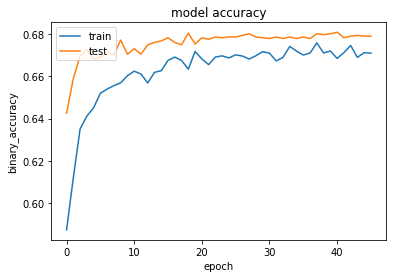

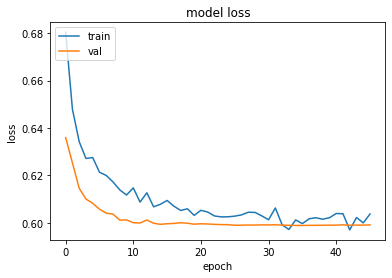

In [45]:
#data máme připravena, tak vytvoříme sequential model, jelikož potřebujeme mít více vrstev, ale máme pouze 1 input (zápas) a output 0;1
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(98)))#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
model.add(keras.layers.Dropout(rate=0.2)) 
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.032), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
              metrics=['binary_accuracy'])

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0047,verbose=1)
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('current_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)#patience-kolik epoch se nezmění val_loss pak stop

history = model.fit(X_train, y_train, epochs=200, shuffle=True,batch_size=118,validation_data=(X_val, y_val), 
                    callbacks=[reduce_lr_callback,checkpoint_callback,early_stopping_callback])#steps
train_predictions= model.predict(X_train)
train_accuracy_score = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {:.2%} \n Error on training data: {:.2%}'.format(train_accuracy_score[1],  1 - train_accuracy_score[1]))#úspěšnost na trénovacím setu   


test_predictions= model.predict(X_test)
test_accuracy_score= model.evaluate(X_test, y_test, verbose=0)# zkusit změnit verbose zde a nahoře na 1 a 2 mělo by to zobrazovat více údajů při tréninku
print('Accuracy on test data: {:.2%} \n Error on test data: {:.2%}'.format(test_accuracy_score[1], 1 - test_accuracy_score[1]))#úspěšnost na testovacím setu

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



Epoch 1/200
56/56 [==============================] - 1s 14ms/step - loss: 0.6735 - binary_accuracy: 0.5771 - val_loss: 0.6516 - val_binary_accuracy: 0.6355

Epoch 00001: val_loss improved from inf to 0.65156, saving model to current_model.h5
Epoch 2/200
56/56 [==============================] - 1s 11ms/step - loss: 0.6557 - binary_accuracy: 0.6102 - val_loss: 0.6322 - val_binary_accuracy: 0.6437

Epoch 00002: val_loss improved from 0.65156 to 0.63221, saving model to current_model.h5
Epoch 3/200
56/56 [==============================] - 1s 11ms/step - loss: 0.6391 - binary_accuracy: 0.6256 - val_loss: 0.6269 - val_binary_accuracy: 0.6670

Epoch 00003: val_loss improved from 0.63221 to 0.62688, saving model to current_model.h5
Epoch 4/200
56/56 [==============================] - 1s 11ms/step - loss: 0.6291 - binary_accuracy: 0.6497 - val_loss: 0.6131 - val_binary_accuracy: 0.6670

Epoch 00004: val_loss improved from 0.62688 to 0.61305, saving model to current_model.h5
Epoch 5/200
56/56 [=

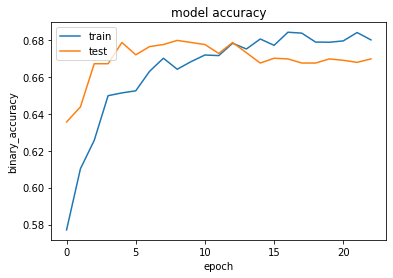

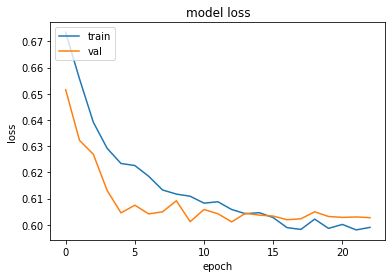

In [65]:
#data máme připravena, tak vytvoříme sequential model, jelikož potřebujeme mít více vrstev, ale máme pouze 1 input (zápas) a output 0;1
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=(98)))#https://towardsdatascience.com/17-rules-of-thumb-for-building-a-neural-network-93356f9930af
model.add(keras.layers.Dropout(rate=0.2)) 
model.add(keras.layers.Dense(512,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(256,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(64,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(32,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.0725), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), #https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/
              metrics=['binary_accuracy'])

reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.004,verbose=1)
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint('current_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)#patience-kolik epoch se nezmění val_loss pak stop

history = model.fit(X_train, y_train, epochs=200, shuffle=True,batch_size=227,validation_data=(X_val, y_val), 
                    callbacks=[reduce_lr_callback,checkpoint_callback,early_stopping_callback])#steps
train_predictions= model.predict(X_train)
train_accuracy_score = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {:.2%} \n Error on training data: {:.2%}'.format(train_accuracy_score[1],  1 - train_accuracy_score[1]))#úspěšnost na trénovacím setu   


test_predictions= model.predict(X_test)
test_accuracy_score= model.evaluate(X_test, y_test, verbose=0)# zkusit změnit verbose zde a nahoře na 1 a 2 mělo by to zobrazovat více údajů při tréninku
print('Accuracy on test data: {:.2%} \n Error on test data: {:.2%}'.format(test_accuracy_score[1], 1 - test_accuracy_score[1]))#úspěšnost na testovacím setu

plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [66]:
#model.save('/content/save/model707.h5')
model= keras.models.load_model("current_model.h5")

scaledData=main_scaler.transform(X)
pred_test= model.predict(scaledData)
scores2 = model.evaluate(scaledData, y, verbose=1)# zkusit změnit verbose zde a nahoře na 1 a 2 mělo by to zobrazovat více údajů při tréninku
print('Accuracy on the whole dataset: {:.2%} \n Error on the whole dataset: {:.2%}'.format(scores2[1], 1 - scores2[1]))#úspěšnost na testovacím setu


#pickle.dump(main_scaler, open("/content/save/scaler707.pkl", 'wb'))#save the scaler 

562/562 [==============================] - 1s 1ms/step - loss: 0.5875 - binary_accuracy: 0.6929
Accuracy on the whole dataset: 69.29% 
 Error on the whole dataset: 30.71%


In [ ]:
main_scaler = pickle.load(open("scaler707.pkl", 'rb'))
Xnew=np.array([[1.6,2.25,26,44,0.63,0.64,0.464,0.578,1.18,0.76,0.72,1.28,88.3,0.82,0.66,1.08,5.2,1.14,0.58,0.73,1.09,73.2,0.71,0.3,1.23,3.0,1.08,0.63,0.74,0.97,75.1,0.65,0.45,1.03,5.9,1.07,0.64,0.72,1.0,74.7,0.67,0.45,1.05,3.3,0.99,0.64,0.72,0.89,67.3,0.59,0.53,0.92,7.0,1.2,0.66,0.73,1.29,85.5,0.76,0.49,1.17,7.6,1.08,0.59,0.72,1.07,66.6,0.67,0.29,1.12,2.5,1.07,0.63,0.72,1.02,72.1,0.67,0.57,1.05,5.1,1.06,0.61,0.74,0.93,72.3,0.67,0.53,1.08,5.4,1.02,0.67,0.72,0.99,74.0,0.62,0.46,0.93,9.4],
               [2.62,1.47,165,129,0.47,0.67,0.5,0.5,1.24,0.68,0.76,1.24,86.3,0.83,0.58,1.23,4.6,1.09,0.67,0.71,1.11,74.9,0.68,0.41,1.01,5.2,1.03,0.68,0.72,0.99,71.8,0.67,0.56,0.99,2.6,0.98,0.72,0.68,0.95,73.2,0.65,0.4,0.90,3.4,0.96,0.67,0.69,0.9,65.9,0.61,0.48,0.91,2.3,1.2,0.68,0.73,1.23,87.0,0.78,0.55,1.15,6.7,1.14,0.58,0.74,1.14,68.7,0.68,0.38,1.17,3.4,1.13,0.67,0.71,1.28,76.3,0.71,0.59,1.05,4.0,1.06,0.63,0.72,0.9,73.9,0.7,0.61,1.10,5.1,1.04,0.69,0.71,1.01,74.2,0.68,0.6,0.99,3.9],
               [2.3,1.52,91,72,0.53,0.67,0.5,0.5,1.11,0.62,0.71,1.08,73.1,0.7,0.3,1.13,2.9,1.08,0.66,0.69,1.16,72.6,0.71,0.62,1.09,3.6,1.06,0.68,0.73,0.95,77.2,0.66,0.51,0.98,3.9,1.03,0.66,0.69,0.95,74.8,0.67,0.68,1.01,3.0,0.96,0.64,0.71,0.87,65.7,0.57,0.5,0.89,5.2,1.13,0.6,0.74,1.0,77.5,0.71,0.57,1.20,5.7,1.18,0.57,0.74,1.17,74.4,0.71,0.27,1.25,3.1,1.15,0.66,0.74,1.11,79.8,0.73,0.52,1.11,4.3,1.04,0.67,0.7,1.03,74.4,0.66,0.62,0.98,3.0,0.95,0.68,0.7,0.85,67.0,0.58,0.5,0.85,4.9],
               [1.6,2.27,43,60,0.55,0.5,0.5,0.51,1.06,0.69,0.69,1.1,75.7,0.7,0.55,1.02,4.5,1.13,0.67,0.68,1.26,77.6,0.76,0.32,1.13,1.8,0.97,0.69,0.68,0.93,71.2,0.64,0.54,0.94,4.2,1.05,0.68,0.68,1.1,74.83,0.7,0.47,1.03,3.5,1.05,0.68,0.68,1.1,74.83,0.7,0.47,1.03,3.5,1.14,0.7,0.72,1.17,83.8,0.74,0.53,1.05,4.5,1.03,0.64,0.68,1.04,69.9,0.66,0.3,1.03,3.3,1.0,0.7,0.68,1.06,71.6,0.64,0.59,0.92,2.8,0.95,0.66,0.69,0.84,65.4,0.62,0.64,0.94,2.4,0.95,0.7,0.68,0.86,69.4,0.62,0.55,0.88,2.5],
               [1.74,2.04,65,78,0.67,0.45,0.569,0.5,1.35,0.51,0.78,1.34,82.4,0.84,0.34,1.66,2.8,1.14,0.61,0.72,1.16,77.0,0.7,0.49,1.16,4.5,1.14,0.63,0.72,1.13,80.0,0.7,0.52,1.11,4.6,1.09,0.63,0.71,1.03,76.0,0.7,0.54,1.11,3.7,1.01,0.62,0.72,0.87,68.7,0.61,0.6,0.98,4.2,1.08,0.68,0.71,1.11,77.7,0.7,0.53,1.04,5.0,1.04,0.68,0.68,1.1,75.5,0.69,0.51,1.01,3.6,1.0,0.63,0.69,0.9,67.8,0.63,0.3,1.00,4.4,0.96,0.74,0.64,1.07,74.4,0.64,0.55,0.86,5.8,0.95,0.63,0.71,0.69,67.2,0.6,0.54,0.96,4.3],
               [1.43,2.6,17,36,0.42,0.8,0.595,0.535,1.3,0.6,0.74,1.35,89.4,0.85,0.46,1.41,5.0,1.07,0.64,0.71,0.98,77.0,0.67,0.44,1.06,5.3,1.07,0.7,0.69,1.2,74.4,0.67,0.29,0.97,3.3,0.98,0.66,0.71,0.84,71.3,0.62,0.45,0.94,4.8,0.71,0.65,0.63,0.5,45.6,0.4,0.46,0.62,1.9,1.29,0.57,0.79,1.13,87.2,0.82,0.53,1.44,3.2,1.28,0.56,0.77,1.3,79.6,0.8,0.26,1.43,3.1,1.23,0.62,0.75,1.27,84.0,0.77,0.51,1.23,6.1,1.06,0.65,0.71,1.08,73.0,0.68,0.52,1.04,5.6,1.06,0.6,0.75,0.88,72.2,0.63,0.46,1.04,3.5],
               [2.91,1.39,128,68,0.6,0.75,0.5,0.516,1.12,0.63,0.69,1.2,75.9,0.73,0.27,1.16,4.6,1.08,0.67,0.69,1.1,76.1,0.71,0.47,1.06,4.5,1.03,0.68,0.71,0.92,75.7,0.68,0.53,1.01,2.6,1.0,0.72,0.71,0.99,76.1,0.64,0.39,0.89,4.7,0.9,0.71,0.69,0.81,64.5,0.59,0.46,0.83,3.1,1.17,0.62,0.71,1.2,78.1,0.76,0.25,1.24,2.6,1.08,0.65,0.71,1.08,76.4,0.67,0.55,1.03,5.5,1.07,0.63,0.73,0.93,72.3,0.68,0.55,1.08,3.4,1.05,0.71,0.68,1.2,76.3,0.68,0.43,0.96,3.8,1.04,0.67,0.72,0.98,72.5,0.67,0.55,1.00,3.7]
])

pokus=main_scaler.transform(Xnew)
model= keras.models.load_model("model707.h5")
ynew=(model.predict([pokus]))
print(ynew)

In [ ]:
n = 2 # Max number of neighbours you want to consider
param_grid = {'n_neighbors': np.arange(n)}
grid = sklearn.model_selection.GridSearchCV(sklearn.neighbors.KNeighborsClassifier(), param_grid)
grid.fit(X,y)
print(grid.best_params_)
#pro 300 nabízí 153

In [ ]:
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)
pd.set_option("expand_frame_repr", True)
pd.set_option("large_repr", "info")
drive.mount('/content/drive')




poznatky-vypadá to, že grenade damage každého hráče je nadbytečná a síť bez této informace vykazuje lepší výsledky!!

optimální batch_size je 128 zjištěno zkoušením

kernel inity
he_uniform>he_normal
lecun uniform>lecun normal 
orthogonal a variance scaling použitelné

bias inity
lecun normal >he normal, variance_scaling
https://www.tensorflow.org/api_docs/python/tf/keras/initializers
val loss u callbacků nebo val_accuracy?
model.add(Dense(512, kernel_initializer=tf.initializers.lecun_uniform,bias_initializer=tf.initializers.lecun_normal))

nejlepší model měl zatím 512,256,128 i když to není doporučováno